# Game Sales Analysis Project

- 목적 : 다음 분기에 어떤 게임을 설계해야 할까
- 지역에 따라서 선호하는 게임 장르가 다를까 라는 질문에 대답을 하셔야합니다.
- 연도별 게임의 트렌드가 있을까 라는 질문에 대답을 하셔야합니다.
- 출고량이 높은 게임에 대한 분석 및 시각화 프로세스가 포함되어야 합니다.

## 라이브러리 로드 및 한글 폰트 설정

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.stats import normaltest

In [89]:
# seaborn 의 set 기능을 통해 폰트, 마이너스 폰트 설정, 스타일 설정을 합니다.
# "Malgun Gothic"
sns.set(font="AppleGothic", 
        rc={"axes.unicode_minus":False},
        style='whitegrid')

In [90]:
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("retina")

<AxesSubplot:title={'center':'한글폰트'}>

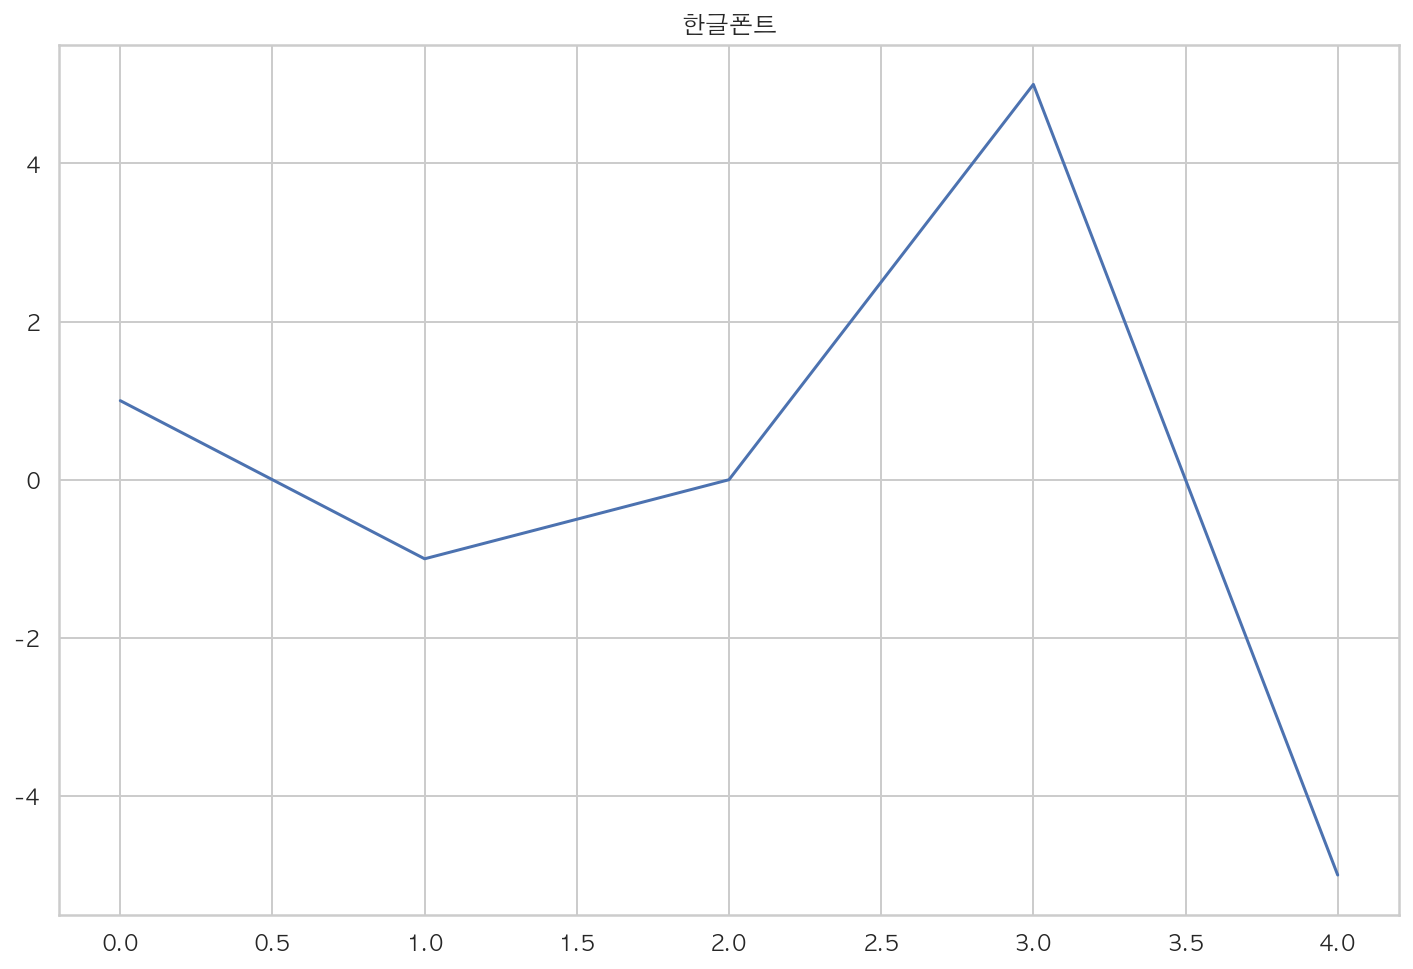

In [91]:
# 한글폰트 설정 확인을 합니다.

pd.Series([1, -1, 0, 5, -5]).plot(title="한글폰트")

In [92]:
# 경고 메세지 없애기

import warnings 

warnings.filterwarnings(action='ignore')

## 데이터 불러오기

In [93]:
df = pd.read_csv("./vgames2.csv")
df.head()

Unnamed: 0                                            Name Platform  \
0           1                    Candace Kane's Candy Factory       DS   
1           2                                  The Munchables      Wii   
2           3  Otome wa Oanesama Boku ni Koi Shiteru Portable      PSP   
3           4                Deal or No Deal: Special Edition       DS   
4           5       Ben 10 Ultimate Alien: Cosmic Destruction      PS3   

     Year      Genre           Publisher NA_Sales EU_Sales JP_Sales  \
0  2008.0     Action           Destineer     0.04        0        0   
1  2009.0     Action  Namco Bandai Games     0.17        0        0   
2  2010.0  Adventure           Alchemist        0        0     0.02   
3  2010.0       Misc           Zoo Games     0.04        0        0   
4  2010.0   Platform         D3Publisher     0.12     0.09        0   

  Other_Sales  
0           0  
1        0.01  
2           0  
3           0  
4        0.04

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   16598 non-null  int64  
 1   Name         16598 non-null  object 
 2   Platform     16598 non-null  object 
 3   Year         16327 non-null  float64
 4   Genre        16548 non-null  object 
 5   Publisher    16540 non-null  object 
 6   NA_Sales     16598 non-null  object 
 7   EU_Sales     16598 non-null  object 
 8   JP_Sales     16598 non-null  object 
 9   Other_Sales  16598 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 1.3+ MB


## 데이터 전처리

### 결측치 확인 및 삭제

In [95]:
# 결측치가 있는지 확인한다.

df.isnull().sum()

Unnamed: 0       0
Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

In [96]:
# 결측치가 있는 행은 삭제한다. 

df = df.dropna(axis=0, how='any')

In [97]:
# drop이 되었는지 결측치를 한번 더 확인한다.

df.isnull().sum()

Unnamed: 0     0
Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
dtype: int64

### 연도 변경

- 20 이하는 +2000
- 20 초과 100 미만은 +1900

In [98]:
def modified_year(year):
    if (0<= year) & (year<=20):
        return year + 2000
    elif (20<year) & (year<=100):
        return year + 1900
    else:
        return year
        
df['Year'] = df['Year'].apply(modified_year)

### sales 컬럼 단위 (K, M)를 삭제

In [99]:
# 문자 K, M 삭제

df['NA_Sales'] = df.NA_Sales.str.replace(r'[a-zA-Z]', "")
df['EU_Sales'] = df.EU_Sales.str.replace(r'[a-zA-Z]', "")
df['JP_Sales'] = df.JP_Sales.str.replace(r'[a-zA-Z]', "")
df['Other_Sales'] = df.Other_Sales.str.replace(r'[a-zA-Z]', "")

df.head()

Unnamed: 0                                            Name Platform  \
0           1                    Candace Kane's Candy Factory       DS   
1           2                                  The Munchables      Wii   
2           3  Otome wa Oanesama Boku ni Koi Shiteru Portable      PSP   
3           4                Deal or No Deal: Special Edition       DS   
4           5       Ben 10 Ultimate Alien: Cosmic Destruction      PS3   

     Year      Genre           Publisher NA_Sales EU_Sales JP_Sales  \
0  2008.0     Action           Destineer     0.04        0        0   
1  2009.0     Action  Namco Bandai Games     0.17        0        0   
2  2010.0  Adventure           Alchemist        0        0     0.02   
3  2010.0       Misc           Zoo Games     0.04        0        0   
4  2010.0   Platform         D3Publisher     0.12     0.09        0   

  Other_Sales  
0           0  
1        0.01  
2           0  
3           0  
4        0.04

### sales 컬럼 type을 float으로 변환

In [100]:
df['NA_Sales'] = df['NA_Sales'].apply(pd.to_numeric)
df['EU_Sales'] = df['EU_Sales'].apply(pd.to_numeric)
df['JP_Sales'] = df['JP_Sales'].apply(pd.to_numeric)
df['Other_Sales'] = df['Other_Sales'].apply(pd.to_numeric)

### sales 컬럼의 단위를 K로 통일 한다.

In [101]:
df['NA_Sales'] = df['NA_Sales'].apply(lambda x: x*1000 if x<15 else x)
df['EU_Sales'] = df['EU_Sales'].apply(lambda x: x*1000 if x<15 else x)
df['JP_Sales'] = df['JP_Sales'].apply(lambda x: x*1000 if x<15 else x)
df['Other_Sales'] = df['Other_Sales'].apply(lambda x: x*1000 if x<15 else x)

In [102]:
df = df.drop('Unnamed: 0', axis=1)

In [103]:
df.head()

Name Platform    Year      Genre  \
0                    Candace Kane's Candy Factory       DS  2008.0     Action   
1                                  The Munchables      Wii  2009.0     Action   
2  Otome wa Oanesama Boku ni Koi Shiteru Portable      PSP  2010.0  Adventure   
3                Deal or No Deal: Special Edition       DS  2010.0       Misc   
4       Ben 10 Ultimate Alien: Cosmic Destruction      PS3  2010.0   Platform   

            Publisher  NA_Sales  EU_Sales  JP_Sales  Other_Sales  
0           Destineer      40.0       0.0       0.0          0.0  
1  Namco Bandai Games     170.0       0.0       0.0         10.0  
2           Alchemist       0.0       0.0      20.0          0.0  
3           Zoo Games      40.0       0.0       0.0          0.0  
4         D3Publisher     120.0      90.0       0.0         40.0

### 총 판매량을 계산하기 위해 Total 컬럼 추가

In [104]:
df['Total'] = df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales']
df.head()

Name Platform    Year      Genre  \
0                    Candace Kane's Candy Factory       DS  2008.0     Action   
1                                  The Munchables      Wii  2009.0     Action   
2  Otome wa Oanesama Boku ni Koi Shiteru Portable      PSP  2010.0  Adventure   
3                Deal or No Deal: Special Edition       DS  2010.0       Misc   
4       Ben 10 Ultimate Alien: Cosmic Destruction      PS3  2010.0   Platform   

            Publisher  NA_Sales  EU_Sales  JP_Sales  Other_Sales  Total  
0           Destineer      40.0       0.0       0.0          0.0   40.0  
1  Namco Bandai Games     170.0       0.0       0.0         10.0  180.0  
2           Alchemist       0.0       0.0      20.0          0.0   20.0  
3           Zoo Games      40.0       0.0       0.0          0.0   40.0  
4         D3Publisher     120.0      90.0       0.0         40.0  250.0

### 데이터 수가 유독 작은 2017, 2020년는 삭제

- 충분한 데이터가 수집 되지 않았을 가능성이 높으므로 삭제

In [105]:
df = df[(df['Year'] != 2020) & (df['Year'] != 2017)]
df.head()

Name Platform    Year      Genre  \
0                    Candace Kane's Candy Factory       DS  2008.0     Action   
1                                  The Munchables      Wii  2009.0     Action   
2  Otome wa Oanesama Boku ni Koi Shiteru Portable      PSP  2010.0  Adventure   
3                Deal or No Deal: Special Edition       DS  2010.0       Misc   
4       Ben 10 Ultimate Alien: Cosmic Destruction      PS3  2010.0   Platform   

            Publisher  NA_Sales  EU_Sales  JP_Sales  Other_Sales  Total  
0           Destineer      40.0       0.0       0.0          0.0   40.0  
1  Namco Bandai Games     170.0       0.0       0.0         10.0  180.0  
2           Alchemist       0.0       0.0      20.0          0.0   20.0  
3           Zoo Games      40.0       0.0       0.0          0.0   40.0  
4         D3Publisher     120.0      90.0       0.0         40.0  250.0

## 연도별 게임의 트렌드 존재 여부

In [106]:
df_genre_year = df.groupby(['Year', 'Genre'])['Total'].sum().unstack()
df_genre_year = df_genre_year.fillna(0)
df_genre_year = df_genre_year.reset_index()
#df_genre_year = df_genre_year.stack()
df_genre_year.head()

Genre    Year   Action  Adventure  Fighting    Misc  Platform   Puzzle  \
0      1980.0    340.0        0.0     770.0  2700.0       0.0      0.0   
1      1981.0  14790.0        0.0       0.0     0.0    6920.0   2250.0   
2      1982.0   6500.0        0.0       0.0   870.0    5030.0  10040.0   
3      1983.0   2860.0      400.0       0.0  2140.0    6930.0    780.0   
4      1984.0   1850.0        0.0       0.0  1450.0     690.0   3140.0   

Genre  Racing  Role-Playing   Shooter  Simulation  Sports  Strategy  
0         0.0           0.0   7070.00         0.0     0.0       0.0  
1       480.0           0.0  10020.00       440.0   780.0       0.0  
2      1570.0           0.0   3810.00         0.0  1060.0       0.0  
3         0.0           0.0    490.00         0.0  3200.0       0.0  
4      5950.0           0.0   4196.93         0.0  6170.0       0.0

### 연도에 따른 장르별 판매량 (라인 그래프)

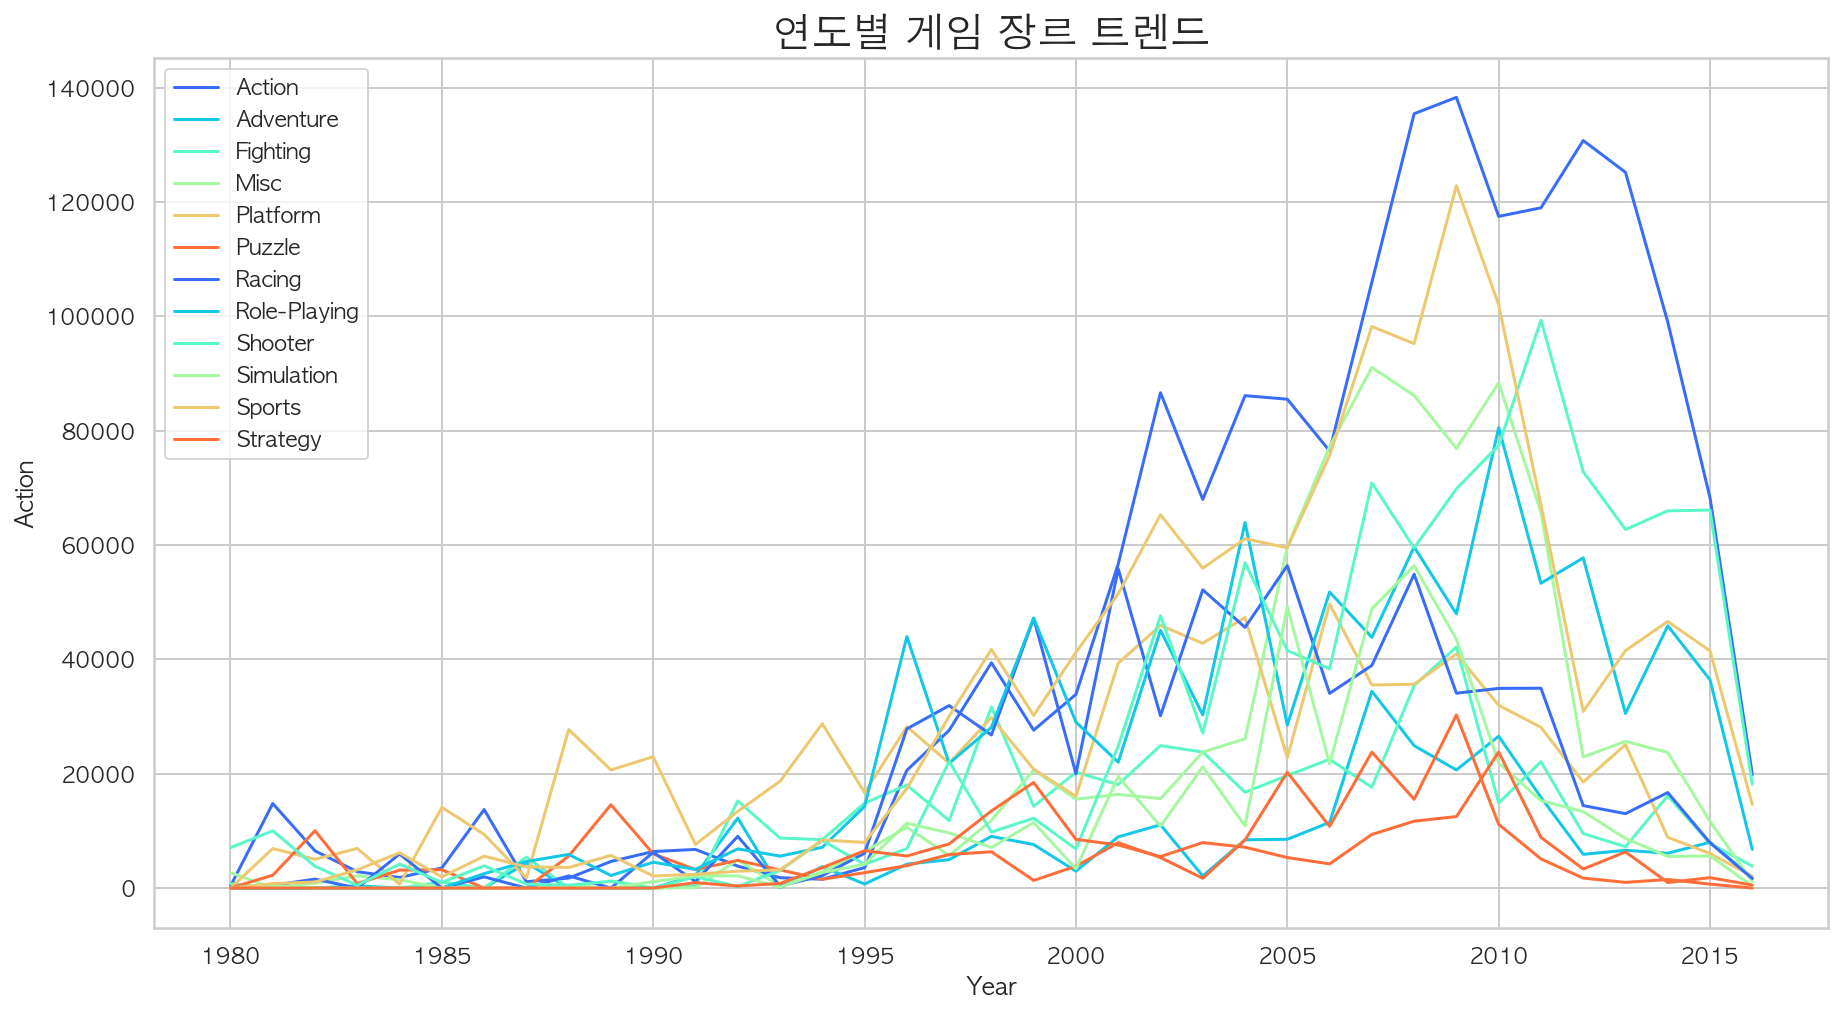

In [20]:
sns.set_palette('rainbow')
plt.figure(figsize=(15, 8))
plt.title('연도별 게임 장르 트렌드', fontsize=20)
genre = df_genre_year.columns
for i in range(1, len(genre)):
    sns.lineplot(data=df_genre_year, x='Year', y=genre[i], label=genre[i])

### 연도에 따른 장르별 판매량 (Scatterplot)

<AxesSubplot:xlabel='Year', ylabel='Total'>

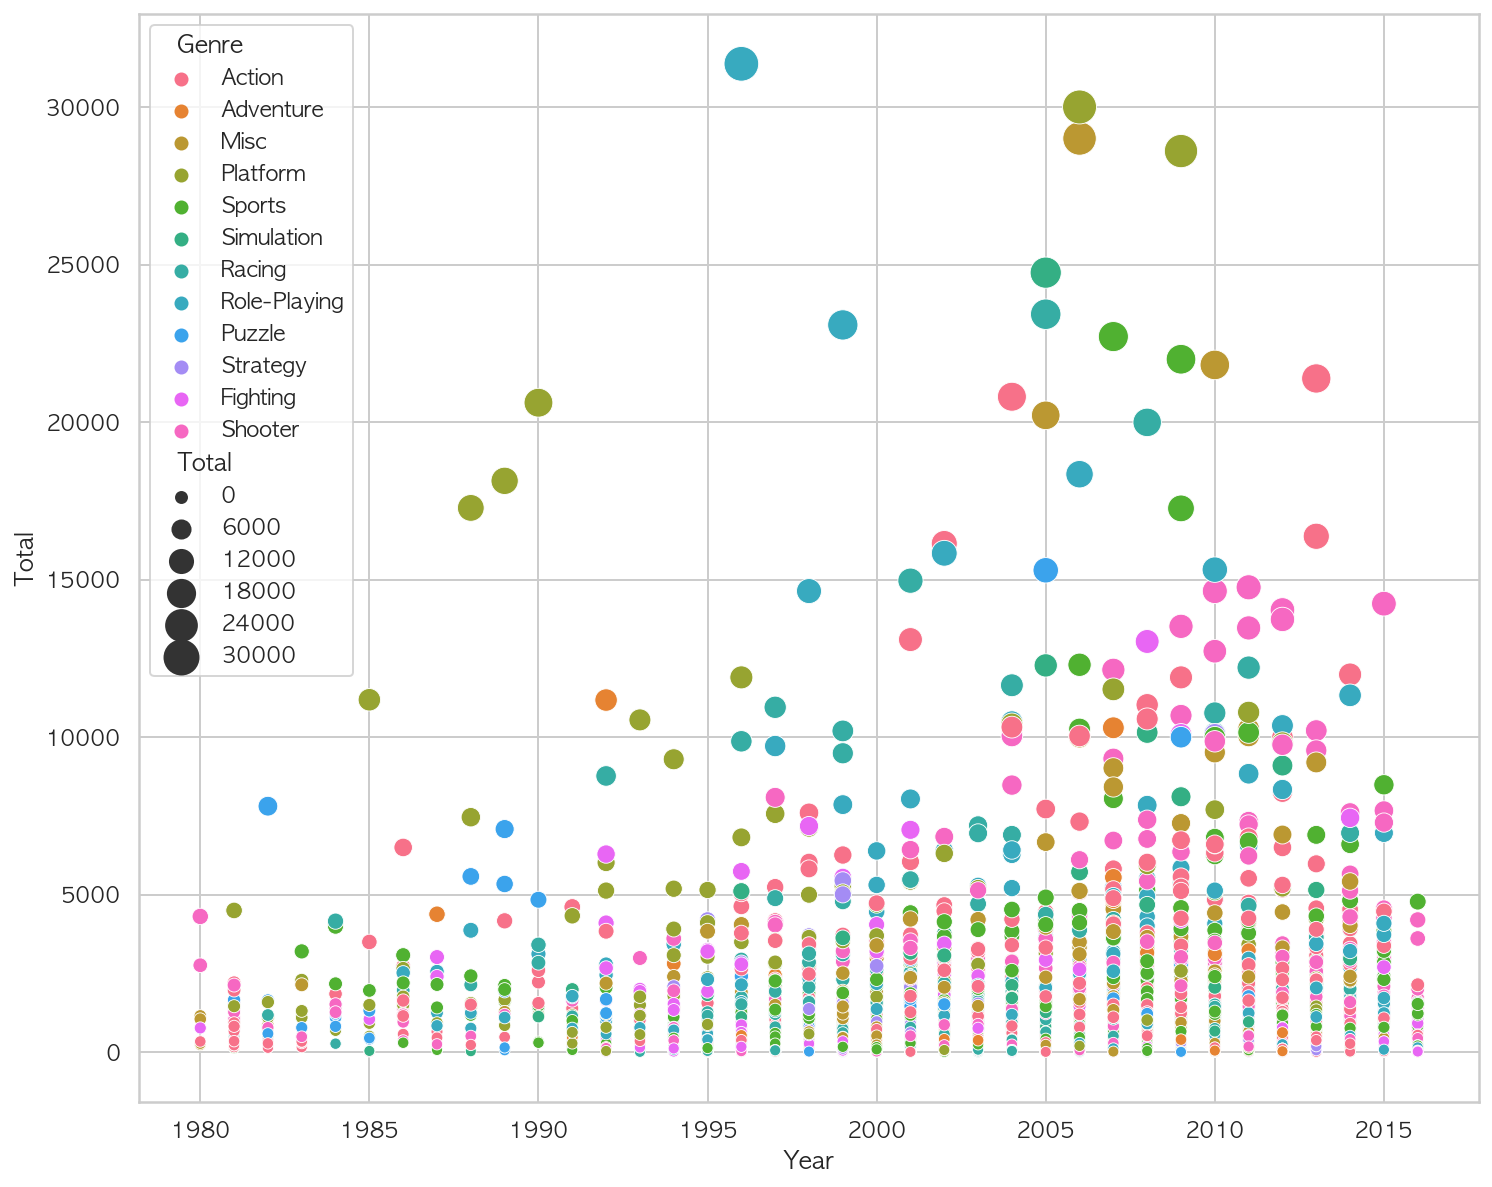

In [21]:
# 연도에 따른 장르 (스캐터)

plt.figure(figsize=(12, 10))
sns.scatterplot(data=df, x="Year", y="Total", 
                hue="Genre", size="Total", sizes=(30, 300))

### 연도에 따른 각 지역별 판매량 (라인 그래프)

In [22]:
# 연도에 따른 각 지역별 판매량을 위한 전처리

df_year_region = df.groupby(['Year'])['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Total'].sum().stack()
df_year_region = df_year_region.reset_index()
df_year_region.rename(columns = {'level_1' : 'Region'}, inplace = True)
df_year_region.rename(columns = {0 : 'Sales'}, inplace = True)
df_year_region.head()

Year       Region    Sales
0  1980.0     NA_Sales  10130.0
1  1980.0     EU_Sales    640.0
2  1980.0     JP_Sales      0.0
3  1980.0  Other_Sales    110.0
4  1980.0        Total  10880.0

Text(0.5, 1.0, '연도에 따른 각 지역별 판매량')

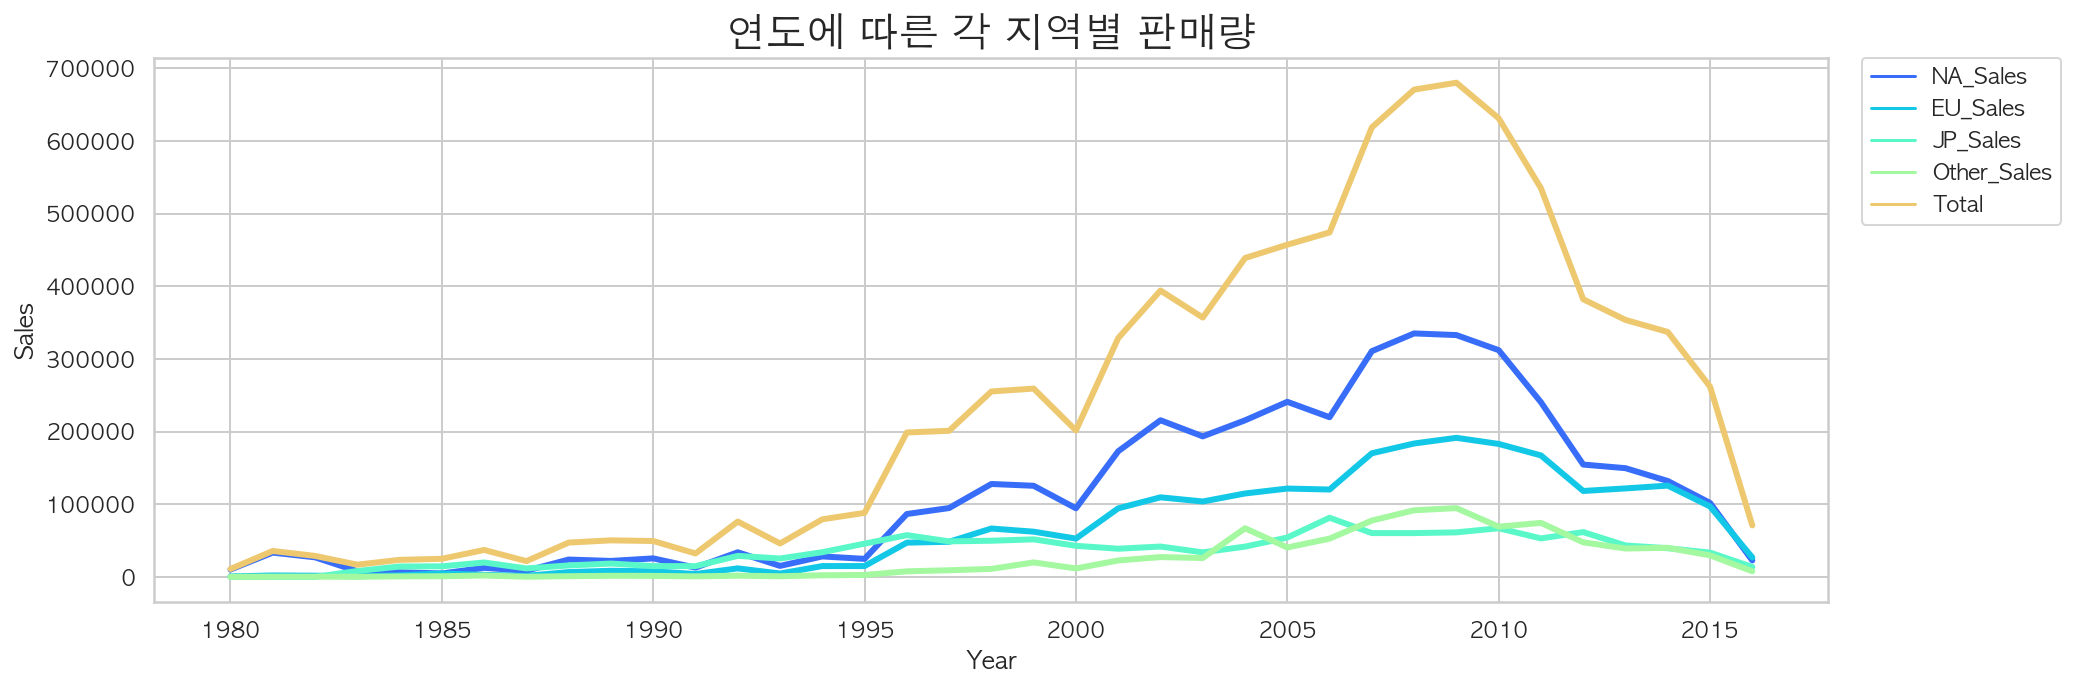

In [23]:
# 연도에 따른 지역별 판매량 그래프 그리기
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_year_region, x="Year", y="Sales", hue="Region", linewidth=3)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title('연도에 따른 각 지역별 판매량', fontsize=20)

### 연도에 따른 게임 판매량 vs. 넷플릭스 수익

In [24]:
# 연도별 Netflix 수입 ($ Million)
# Data Source : Netflix (https://ir.netflix.net/financials)

netflix = pd.read_csv('./netflix.csv')
netflix.head()

Year  Revenue
0  2003     1.41
1  2004     2.48
2  2005     4.02
3  2006     6.15
4  2007     7.32

In [25]:
df_year = df.groupby(['Year'])['Total'].sum().reset_index()
df_year['Total'] = df_year['Total']//1000

df_netflix = pd.merge(df_year, netflix, how='right', on='Year')
df_netflix.columns = ['Year', 'Game Sales', 'Netflix Revenue']
df_netflix.head()

Year  Game Sales  Netflix Revenue
0  2003.0       356.0             1.41
1  2004.0       438.0             2.48
2  2005.0       457.0             4.02
3  2006.0       474.0             6.15
4  2007.0       618.0             7.32

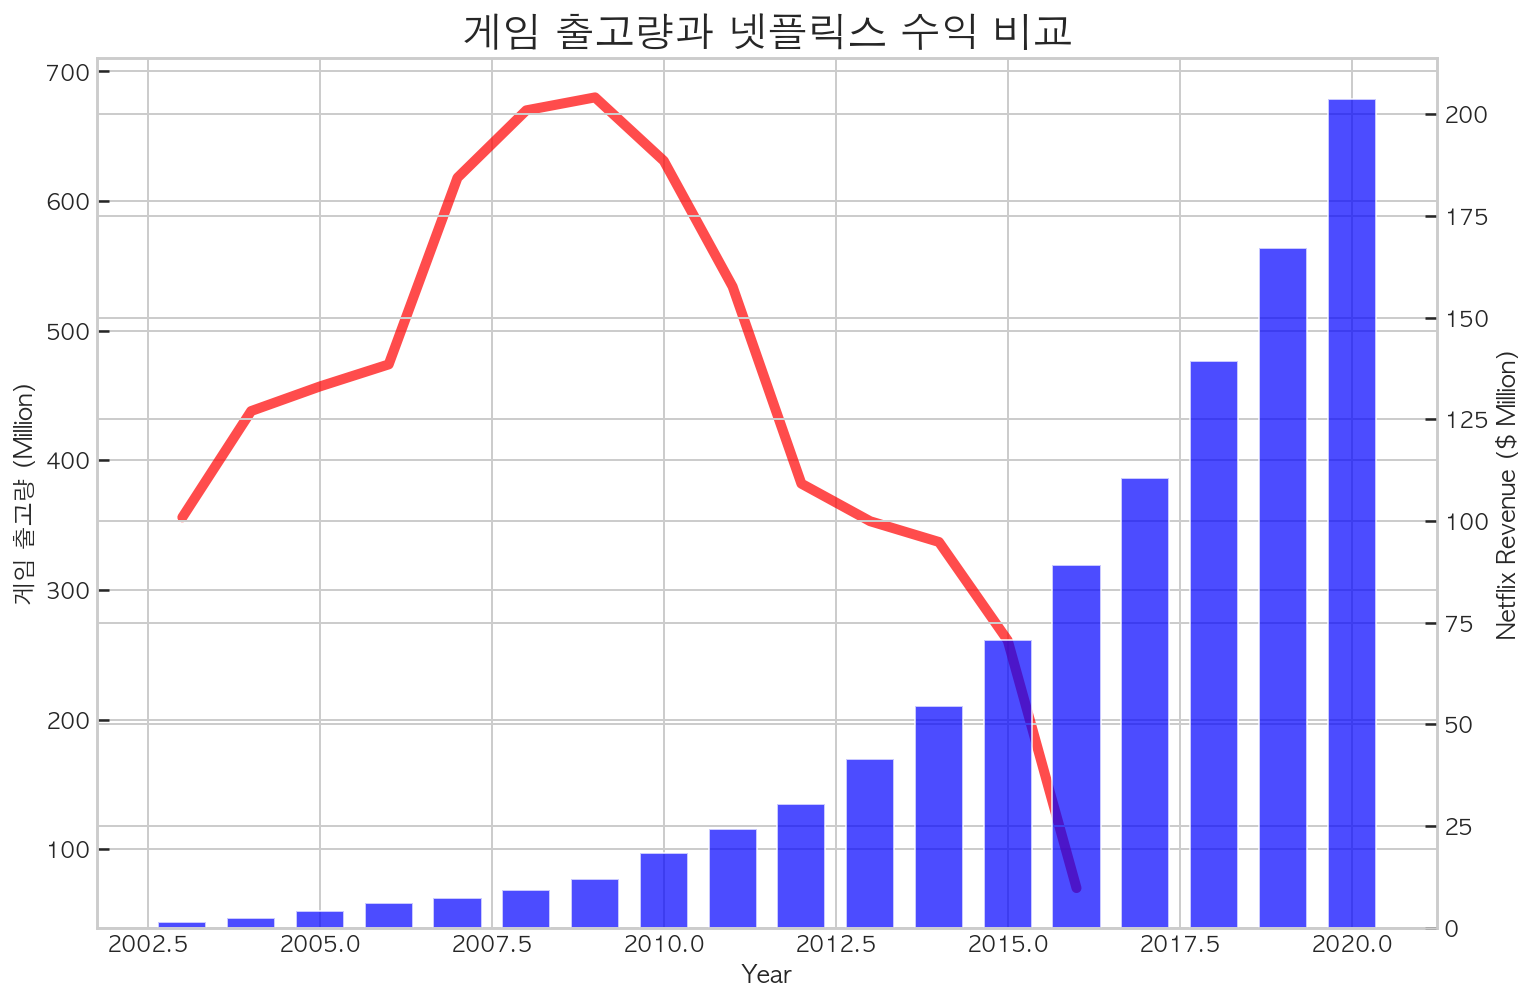

In [26]:
plt.rcParams['figure.figsize'] = (12, 8)
fig, ax1 = plt.subplots()

ax1.plot(df_netflix['Year'], df_netflix['Game Sales'], color='red', 
         markersize=7, linewidth=5, alpha=0.7, label='출고량')
ax1.set_ylabel('게임 출고량 (Million)')
ax1.set_xlabel('Year')

ax1.tick_params(axis='both', direction='in')

ax2 = ax1.twinx()
ax2.bar(df_netflix['Year'], df_netflix['Netflix Revenue'], color='blue', 
        label='Netflix Revenue', alpha=0.7, width=0.7)

ax2.set_ylabel('Netflix Revenue ($ Million)')
ax2.tick_params(axis='y', direction='in')

plt.title('게임 출고량과 넷플릭스 수익 비교', fontsize=20)
plt.show()

### 연도별 TOP 10 플랫폼 트렌드

In [27]:
# 연도에 따른 각 플랫폼별 판매량.

df_year_platform = df.groupby(['Year', 'Platform'])['Total'].sum()
df_year_platform = df_year_platform.reset_index()
df_year_platform.head()

Year Platform    Total
0  1980.0     2600  10880.0
1  1981.0     2600  35680.0
2  1982.0     2600  28880.0
3  1983.0     2600   5840.0
4  1983.0      NES  10960.0

In [28]:
# 판매량이 가장 높은 10개의 플랫폼 리스트 만들기.

df_platform = df_year_platform.groupby('Platform')['Total'].sum().to_frame()
df_platform = df_platform.sort_values(by='Total', ascending=False).head(10)
df_platform = df_platform.reset_index()
platform_list = df_platform['Platform'].array

# 판매량이 가장 높은 10개의 플랫폼의 정보를 df_platform_top10에 담기.
df_platform_top10 = pd.DataFrame()

for i in range(len(platform_list)):
    df_p = df_year_platform[df_year_platform['Platform']==platform_list[i]]
    df_platform_top10 = df_platform_top10.append(df_p)
    
df_platform_top10.head()

Year Platform     Total
94   2000.0      PS2   39170.0
104  2001.0      PS2  163730.0
113  2002.0      PS2  205380.0
119  2003.0      PS2  184310.0
125  2004.0      PS2  220460.0

Text(0.5, 1.0, '연도에 따른 TOP10 플랫폼별 판매량')

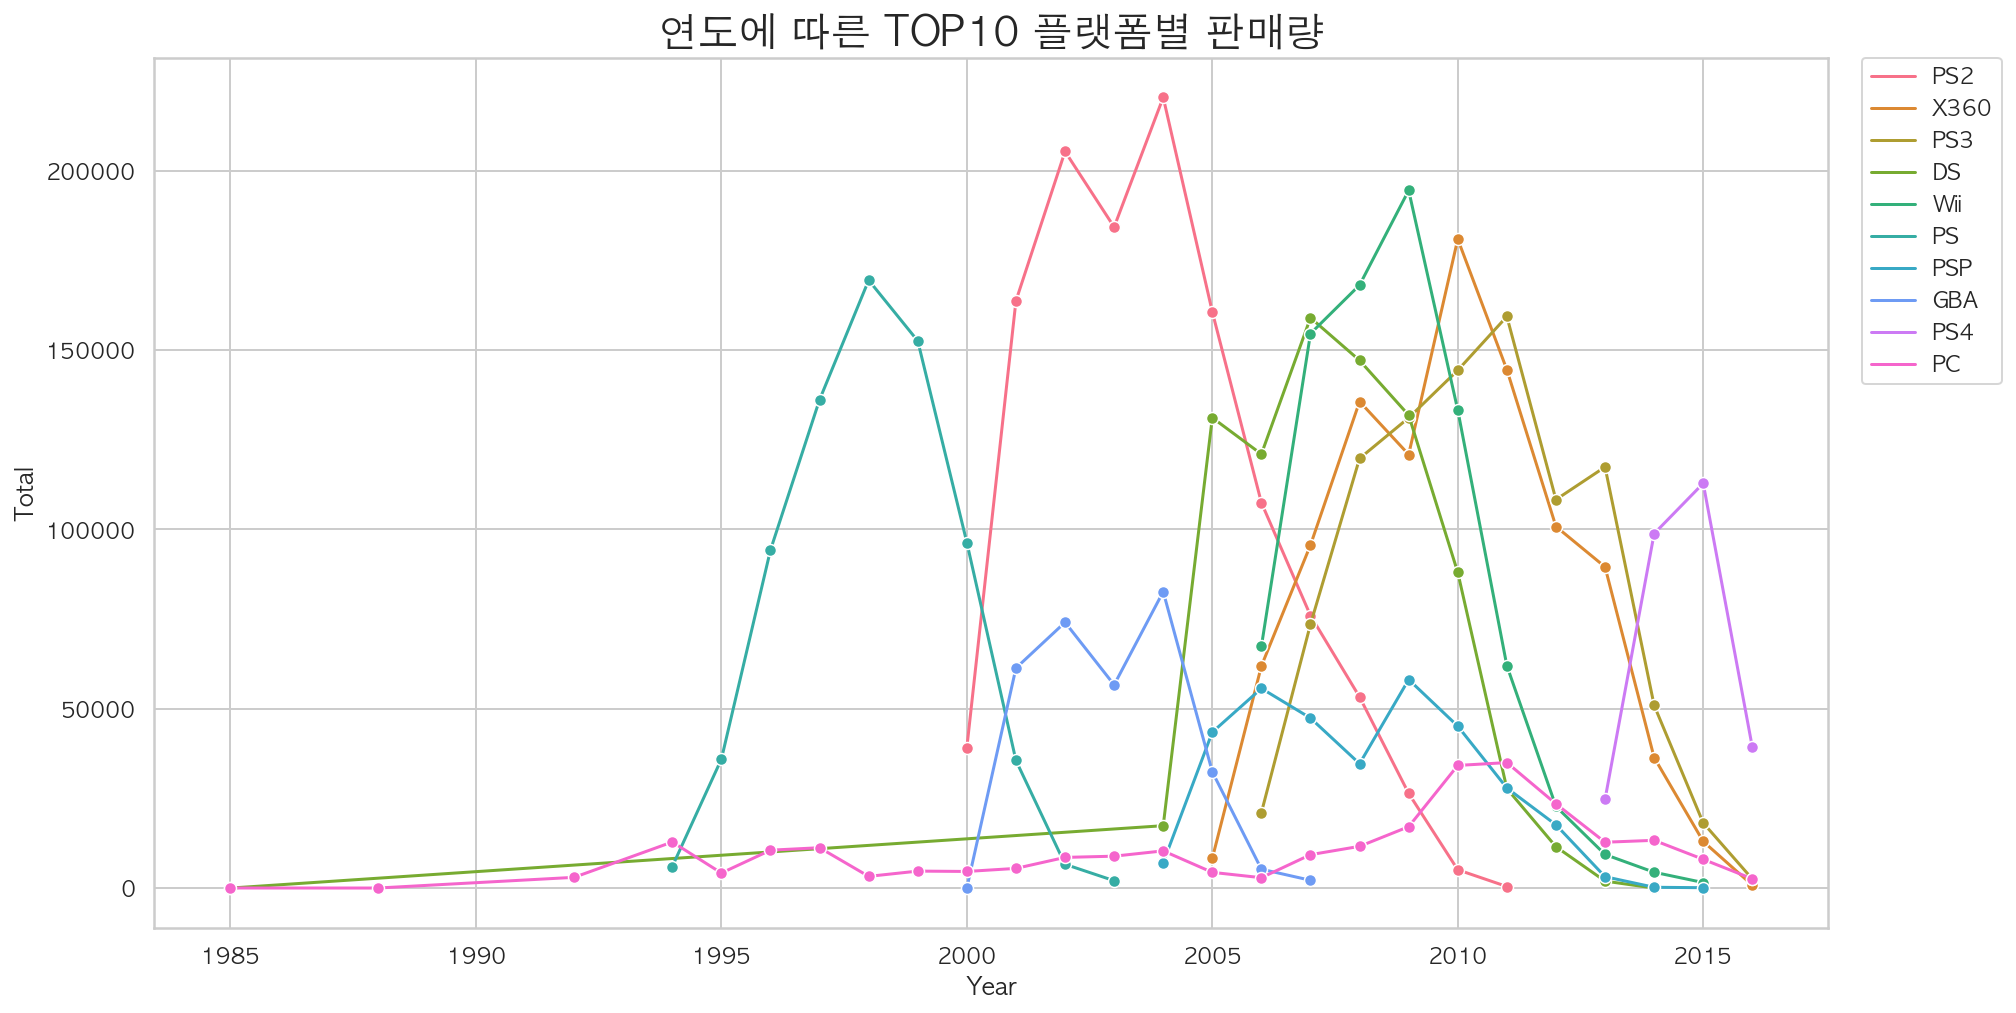

In [29]:
# 연도에 따른 탑10 플랫폼별 판매량 그래프 그리기
plt.figure(figsize=(15, 8))

sns.lineplot(data=df_platform_top10, x="Year", y="Total", hue="Platform", marker='o')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title('연도에 따른 TOP10 플랫폼별 판매량', fontsize=20)

### 시대별 (10년 단위) 게임 장르 트렌드

In [30]:
df_period = df.groupby(['Year', 'Genre'])['Genre'].count().unstack()
df_period = df_period.fillna(0)
df_period.head()

Genre   Action  Adventure  Fighting  Misc  Platform  Puzzle  Racing  \
Year                                                                  
1980.0     1.0        0.0       1.0   4.0       0.0     0.0     0.0   
1981.0    25.0        0.0       0.0   0.0       3.0     2.0     1.0   
1982.0    18.0        0.0       0.0   1.0       5.0     3.0     2.0   
1983.0     7.0        1.0       0.0   1.0       5.0     1.0     0.0   
1984.0     1.0        0.0       0.0   1.0       1.0     3.0     3.0   

Genre   Role-Playing  Shooter  Simulation  Sports  Strategy  
Year                                                         
1980.0           0.0      2.0         0.0     0.0       0.0  
1981.0           0.0     10.0         1.0     4.0       0.0  
1982.0           0.0      5.0         0.0     2.0       0.0  
1983.0           0.0      1.0         0.0     1.0       0.0  
1984.0           0.0      3.0         0.0     2.0       0.0

In [31]:
df_period.columns

Index(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy'],
      dtype='object', name='Genre')

In [34]:

# df_period.loc['1980-1989', :] = df_period.loc[[1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989]].sum()
# df_period.loc['1990-1999', :] = df_period.loc[[1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999]].sum()
# df_period.loc['2000-2009', :]= df_period.loc[[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009]].sum()
# df_period.loc['2010-2020', :] = df_period.loc[[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2020]].sum()

df_period.loc['1980-1989', :] = df_period.loc[[1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0]].sum()
df_period.loc['1990-1999', :] = df_period.loc[[1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0]].sum()
df_period.loc['2000-2009', :]= df_period.loc[[2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0]].sum()
df_period.loc['2010-2020', :] = df_period.loc[[2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0]].sum()


In [35]:
df_period = df_period.loc[['1980-1989', '1990-1999', '2000-2009', '2010-2020']]
df_period.reset_index()
df_period

Genre      Action  Adventure  Fighting   Misc  Platform  Puzzle  Racing  \
Year                                                                      
1980-1989    66.0        2.0       4.0    8.0      33.0    19.0     8.0   
1990-1999   161.0       97.0     193.0  115.0     125.0    71.0   181.0   
2000-2009  1579.0      631.0     442.0  997.0     565.0   361.0   797.0   
2010-2020  1433.0      538.0     196.0  561.0     150.0   115.0   233.0   

Genre      Role-Playing  Shooter  Simulation  Sports  Strategy  
Year                                                            
1980-1989           9.0     30.0         3.0    22.0       0.0  
1990-1999         171.0    137.0        86.0   304.0     123.0  
2000-2009         729.0    718.0       551.0  1404.0     379.0  
2010-2020         554.0    395.0       205.0   569.0     167.0

<AxesSubplot:title={'center':'시대별 게임 장르 트렌드'}, xlabel='Year', ylabel='판매량 (K)'>

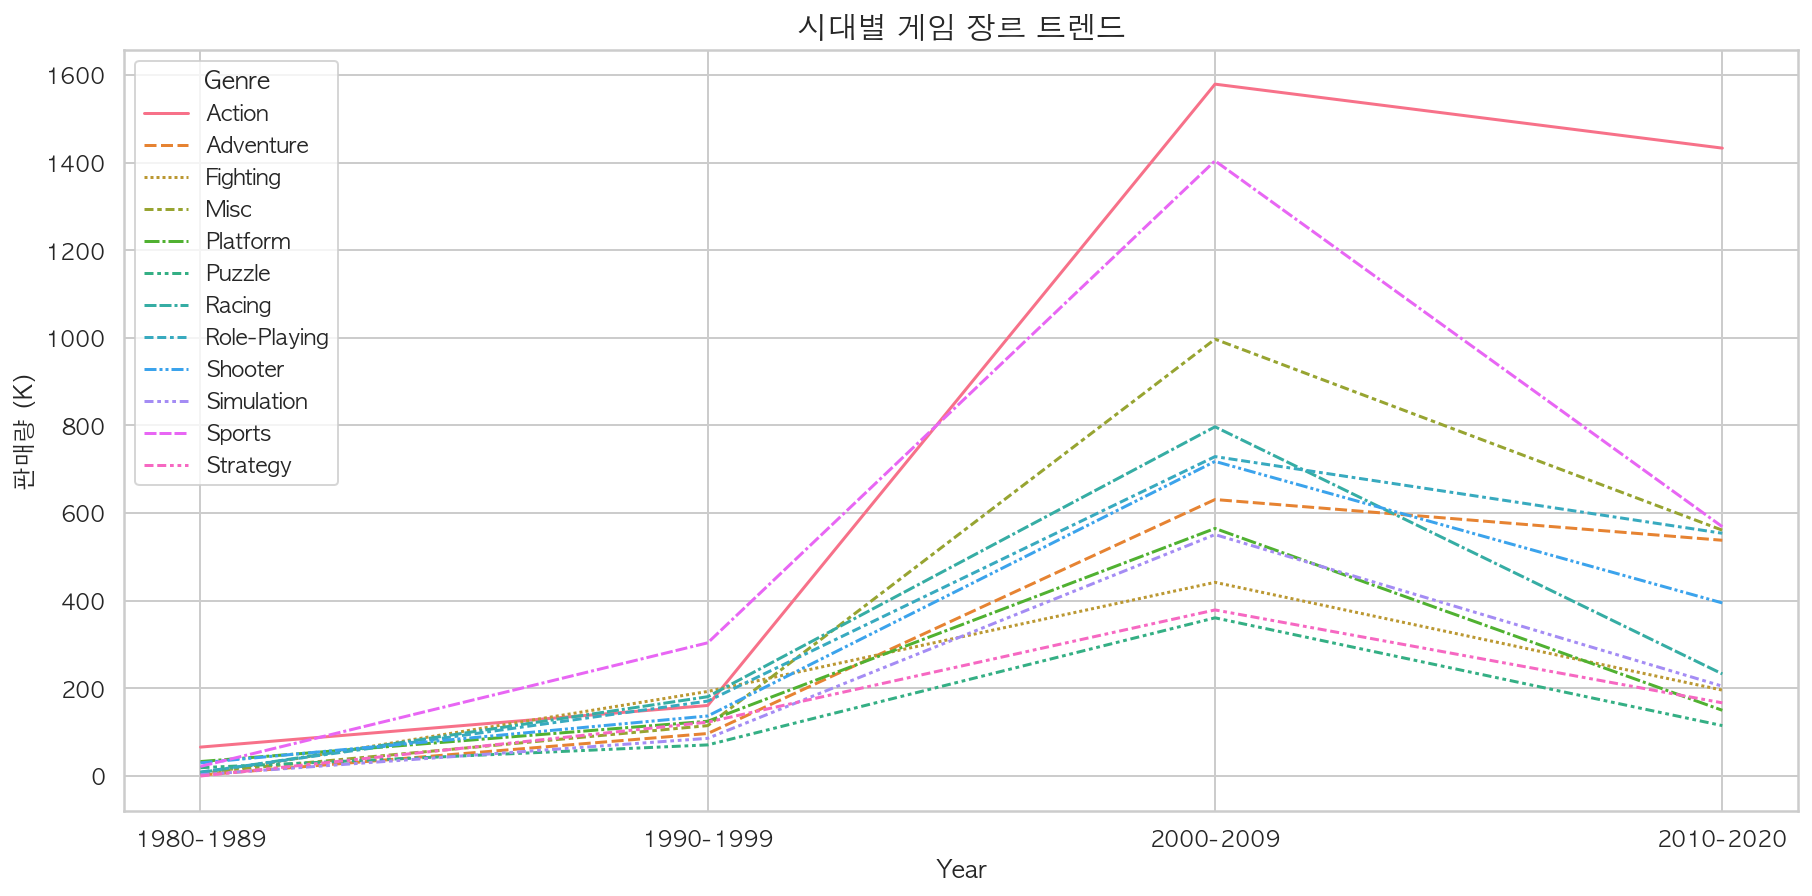

In [36]:
plt.figure(figsize=(15, 7))
plt.title('시대별 게임 장르 트렌드', fontsize=15)
plt.ylabel('판매량 (K)')
sns.lineplot(data=df_period)

In [37]:
df_genre_period = df_period.unstack().reset_index()
df_genre_period.columns = ['Genre', 'Year', 'Total']
df_genre_period.head()

Genre       Year   Total
0     Action  1980-1989    66.0
1     Action  1990-1999   161.0
2     Action  2000-2009  1579.0
3     Action  2010-2020  1433.0
4  Adventure  1980-1989     2.0

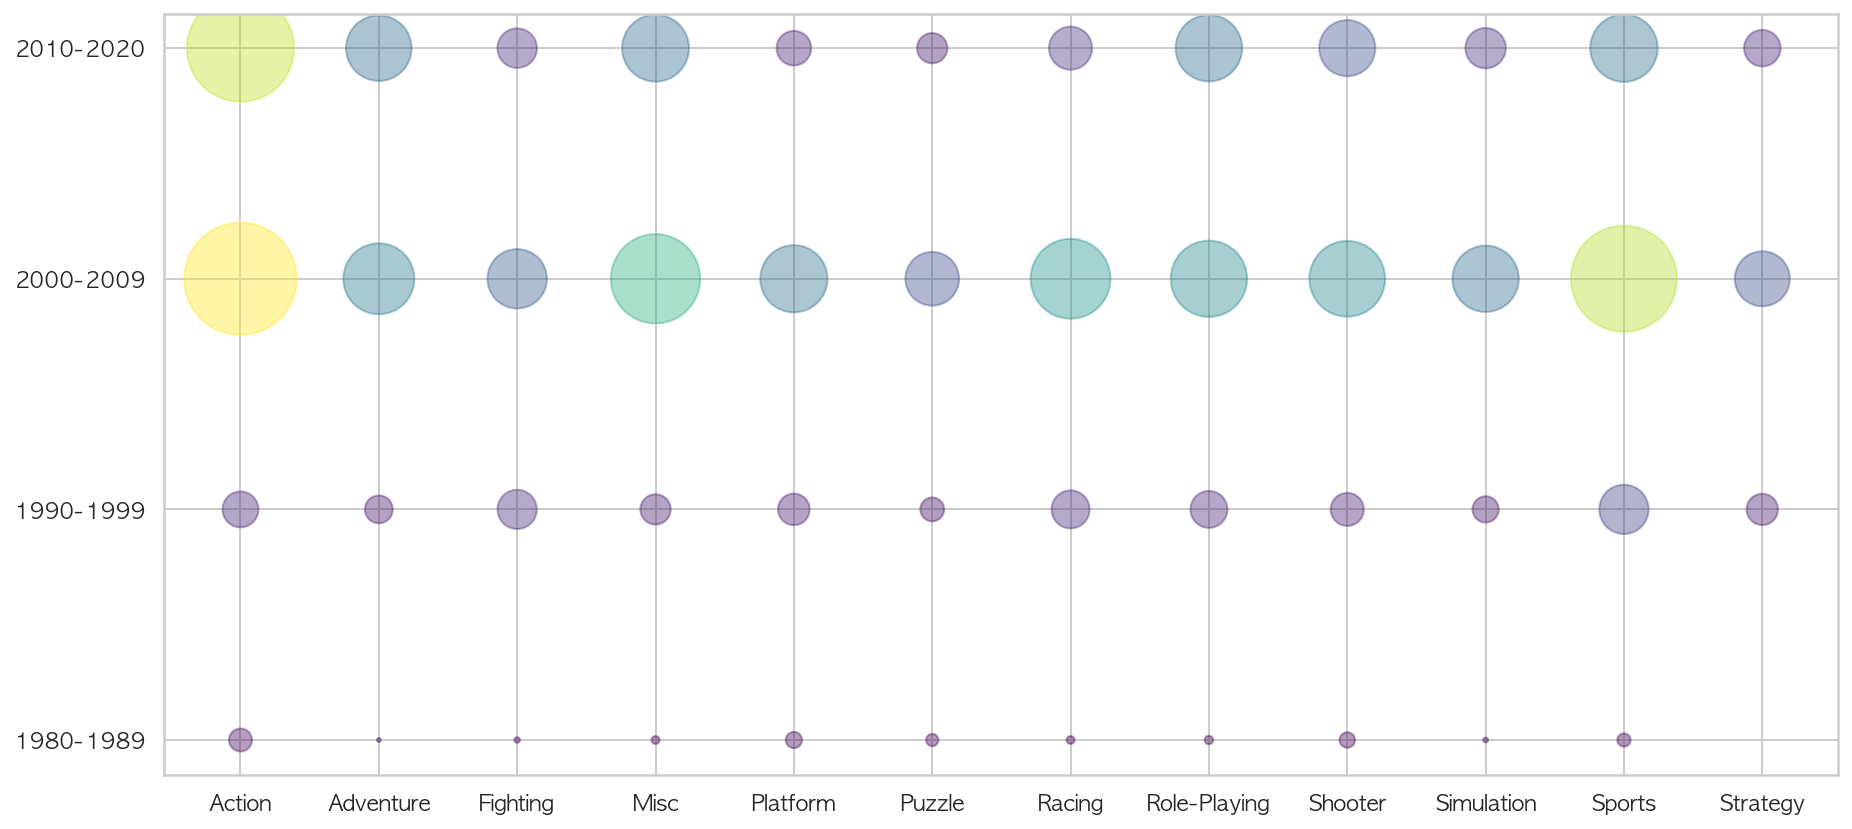

In [38]:
plt.figure(figsize=(15, 7))

plt.scatter(df_genre_period['Genre'], df_genre_period['Year'], alpha=0.4, 
            s=df_genre_period['Total']*2, c=df_genre_period['Total'], cmap='viridis')
plt.show()

**라인 그래프를 통해 각 시대별로 어떤 장르 게임의 판매량이 많았는지 알 수 있다.**

- 빨간색 실선을 의미하는 Action 장르는 1990-1999 구각 이후로 급격하게 성장하였다. 
- 1990-1999부터 10년동안 전 장르의 판매량이 증가하였다. 
- 하지만, 2000-2009 이후로 전반적으로 판매량이 감소하는 추세이다. 

**위 그래프를 다음과 같이 bar로 나타낼 수 있다.**

- 2000-2009구간과 2010-2020 구간에서 Action 장르의 우세가 압도적이다. 

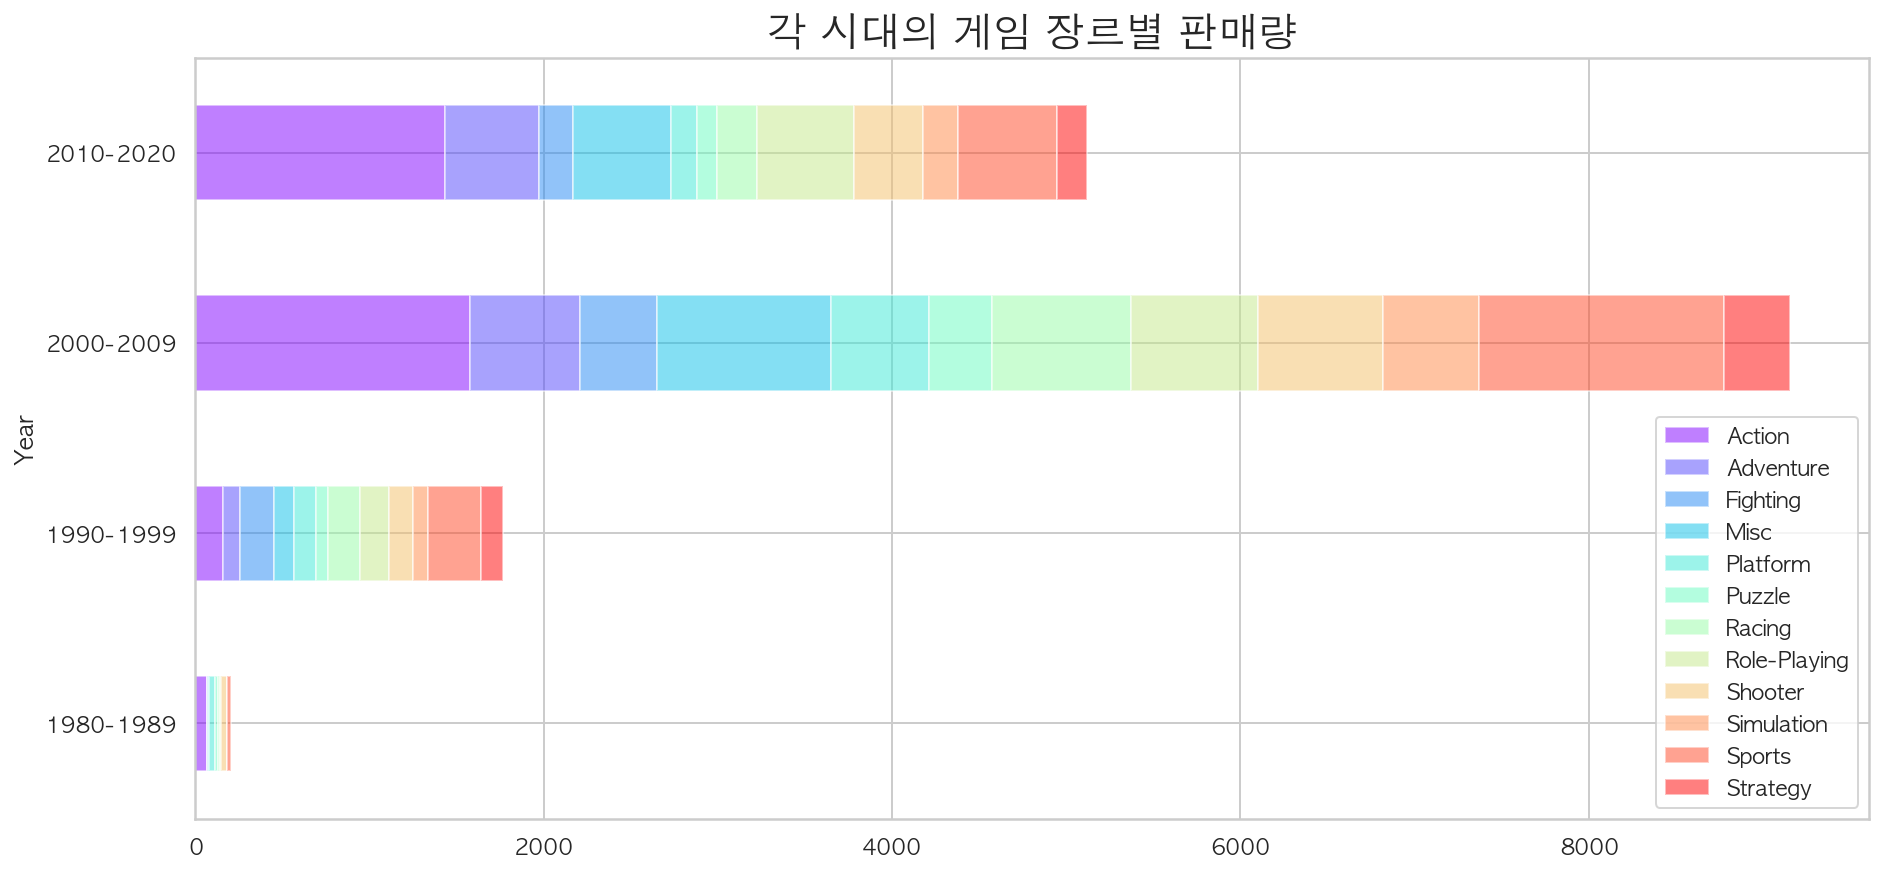

In [39]:
df_period.plot(kind='barh', stacked=True, figsize=(15, 7), cmap='rainbow', alpha=0.5 )
plt.title('각 시대의 게임 장르별 판매량', fontsize=20)
plt.legend(loc='best')

## 출고량이 높은 게임에 대한 분석

### Total 판매량이 가장 높은 30개의 데이터

In [40]:
# 판매량이 가장 높은 30개의 데이터를 df_top_sales에 담는다.

df_top30 = df.sort_values(by='Total', ascending=False).head(30)
df_top30.head()

Name Platform    Year         Genre Publisher  \
7829    Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo   
6937       New Super Mario Bros.       DS  2006.0      Platform  Nintendo   
3014                    Wii Play      Wii  2006.0          Misc  Nintendo   
16531  New Super Mario Bros. Wii      Wii  2009.0      Platform  Nintendo   
11137                 Nintendogs       DS  2005.0    Simulation  Nintendo   

       NA_Sales  EU_Sales  JP_Sales  Other_Sales    Total  
7829    11270.0    8890.0   10220.0       1000.0  31380.0  
6937    11380.0    9230.0    6500.0       2900.0  30010.0  
3014    14030.0    9200.0    2930.0       2850.0  29010.0  
16531   14590.0    7060.0    4700.0       2260.0  28610.0  
11137    9070.0   11000.0    1930.0       2750.0  24750.0

### TOP 30 게임의 장르별 판매량

In [41]:
plt.figure(figsize=(12, 4))
df_top30_genre = df_top30.groupby('Genre')['Total'].sum().to_frame()

<Figure size 864x288 with 0 Axes>

In [42]:
df_top30_genre = df_top30_genre.reset_index()
df_top30_genre = df_top30_genre.sort_values(by='Total', ascending=False)
df_top30_genre.head()

Genre      Total
5  Role-Playing  118620.00
2      Platform  114660.00
0        Action   74730.00
1          Misc   71050.00
8        Sports   61985.75

<AxesSubplot:title={'center':'TOP 30 게임의 장르별 판매량'}, xlabel='Genre', ylabel='Total'>

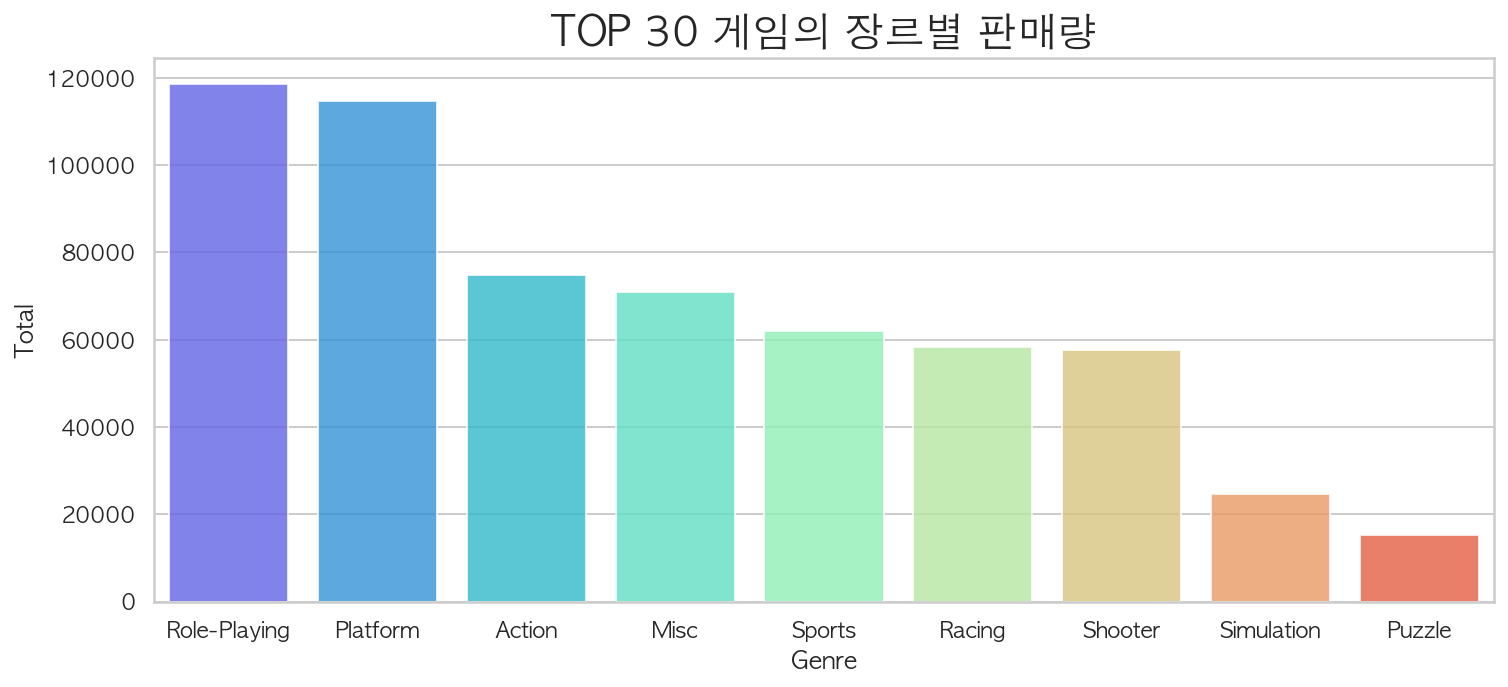

In [43]:
plt.figure(figsize=(12, 5))
plt.title('TOP 30 게임의 장르별 판매량', fontsize=20)
sns.barplot(data=df_top30_genre, x="Genre", y="Total", palette="rainbow", alpha=0.8)

### TOP 30 플랫폼 별 판매량

- 세계 판매량 TOP30 게임의 플랫폼 별 판매량을 확인합니다.

> 그래프를 통해 DS, Wii, GB의 점유율이 가장 높은 것을 알 수 있다. 시장 점유율이 높은 플랫폼의 게임 개발을 우선되야 함을 알 수 있습니다.

In [44]:
# Platform에 따른 총 판매 (total)을 df_top30_platform에 담습니다.
df_top30_platform = df_top30.groupby(['Platform'])['Total'].sum()
df_top30_platform = df_top30_platform.to_frame()

# TOP30 게임의 판매율 구합니다.
sum = df_top30_platform['Total'].sum()

df_top30_platform["판매율 (%)"] = round((df_top30_platform["Total"] / sum) * 100, 2)
df_top30_platform.head()

Total  판매율 (%)
Platform                   
DS        147380.0    24.68
GB         87250.0    14.61
GBA        15840.0     2.65
NES        17280.0     2.89
PS2        51930.0     8.70

Text(0.5, 1.0, 'TOP 30 플랫폼에 따른 판매율')

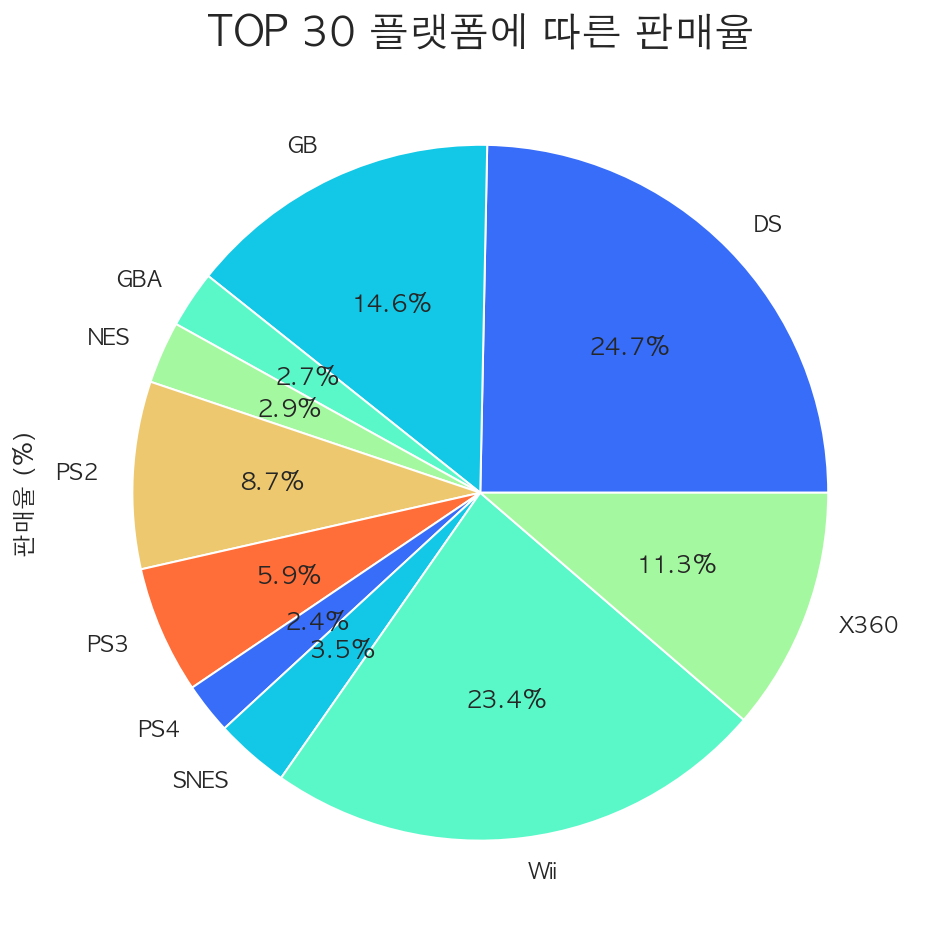

In [45]:
# TOP 30 플랫폼에 따른 판매율

plt.figure(figsize=(8, 8))
df_top30_platform['판매율 (%)'].plot(kind = "pie", autopct = '%1.1f%%')
plt.title('TOP 30 플랫폼에 따른 판매율', fontsize=20)

## 지역에 따른 게임 출고 분석

### 지역에 따라 선호하는 게임 장르

In [48]:
df_genre_region = df.groupby(['Genre'])['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'].sum()
df_genre_region.head()

NA_Sales  EU_Sales  JP_Sales  Other_Sales
Genre                                                
Action     858750.00  523630.0  166580.0     193980.0
Adventure  101790.00   73650.0   61860.0      16700.0
Fighting   220350.00   99900.0   87140.0      46140.0
Misc       394730.00  208150.0  114170.0      82630.0
Platform   416329.08  200630.0  130530.0      51450.0

<AxesSubplot:>

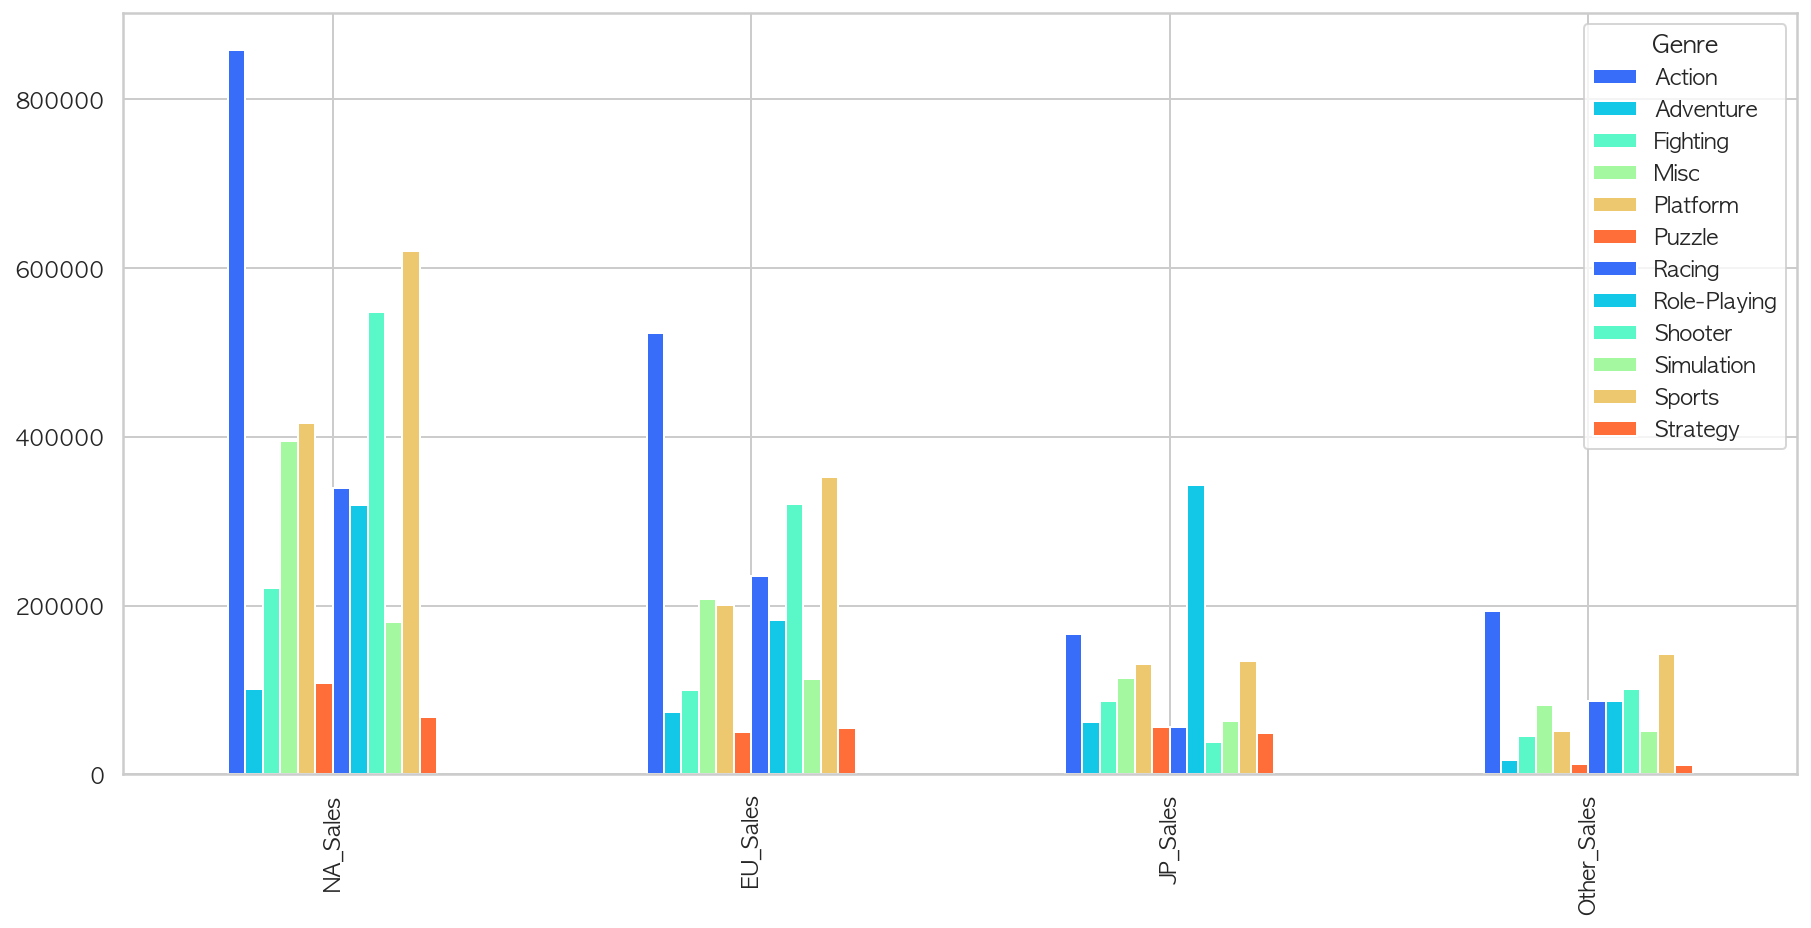

In [49]:
sns.set_palette('rainbow')
df_genre_region.T.plot.bar(figsize=(15,7))

Text(0.5, 1.0, '지역별 게임 장르 판매량')

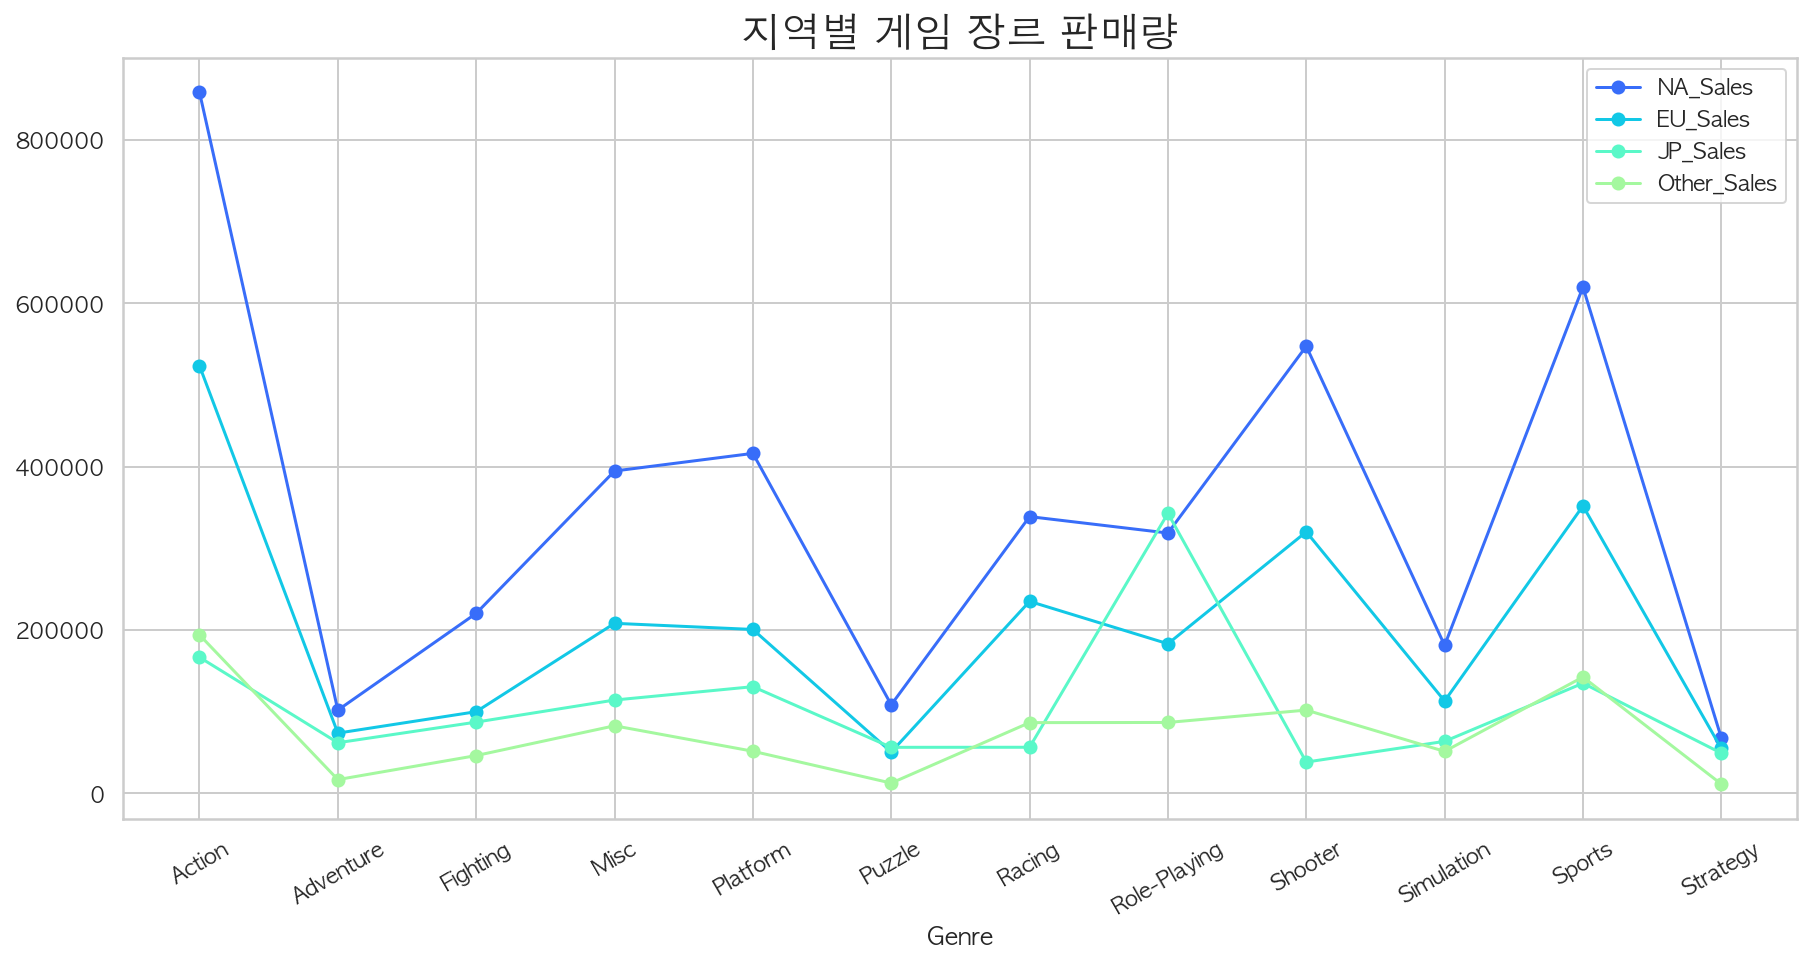

In [50]:
df_genre_region.plot(figsize=(15,7), marker='o')
ax = plt.subplot()
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax.set_xticklabels(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle', 'Racing',
                    'Role-Playing', 'Shooter', 'Simulation', 'Sports', 'Strategy'], rotation=30)

plt.title("지역별 게임 장르 판매량", fontsize=20)

> 네 개의 지역마다 선호하는 장르가 조금씩 상이한 것을 확인할 수 있습니다. NA, EU, Other 지역에서 Action 장르를 가장 선호하지만, JP 지역에서는 Role-Playing 장르를 가장 선호하는 것으로 나타났습니다. 

### 각 지역별 총 판매량을 지도 위에 표시하기

In [51]:
import geopandas as gpd

continent_geo = pd.read_csv("./continent_geo.csv")
continent_geo.head()

continent                                           geometry
0  Other_Sales  POLYGON ((33.90371119710453 -0.950000000000000...
1  Other_Sales  POLYGON ((-8.665589565454809 27.65642588959236...
2  Other_Sales  POLYGON ((29.33999759290035 -4.499983412294092...
3  Other_Sales  POLYGON ((41.58513 -1.68325, 40.993 -0.85829, ...
4  Other_Sales  POLYGON ((39.20222 -4.67677, 37.7669 -3.67712,...

In [52]:
# 각 지역에 따른 장르별 판매량

df_genre = df.groupby(['Genre'])['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'].sum().unstack().to_frame().reset_index()
df_genre.rename(columns = {'level_0' : 'continent'}, inplace = True)
df_genre.rename(columns = {0 : 'Sales'}, inplace = True)
df_genre.head()

continent      Genre      Sales
0  NA_Sales     Action  858750.00
1  NA_Sales  Adventure  101790.00
2  NA_Sales   Fighting  220350.00
3  NA_Sales       Misc  394730.00
4  NA_Sales   Platform  416329.08

In [53]:
# 각 지역별 총 판매량

df_continet = df_genre.drop('Genre', axis=1)
df_continet = df_continet.groupby(['continent'])['Sales'].sum().to_frame()
df_continet

Sales
continent              
EU_Sales     2414529.02
JP_Sales     1301310.00
NA_Sales     4174602.30
Other_Sales   883250.00

In [54]:
# 각 지역의 geometry 정보 병합

df_continet = pd.merge(df_continet, continent_geo, how='inner', on='continent')
df_continet.head()

continent       Sales                                           geometry
0  EU_Sales  2414529.02  MULTIPOLYGON (((178.7253 71.0988, 180.00000000...
1  EU_Sales  2414529.02  MULTIPOLYGON (((15.14282 79.67431000000001, 15...
2  EU_Sales  2414529.02  MULTIPOLYGON (((-51.65779741067889 4.156232408...
3  EU_Sales  2414529.02  POLYGON ((11.02736860519687 58.85614940045936,...
4  EU_Sales  2414529.02  POLYGON ((28.17670942557794 56.16912995057879,...

In [55]:
from geopandas import GeoDataFrame
import shapely.wkt

df_continet = GeoDataFrame(df_continet)
df_continet['geometry'] = df_continet['geometry'].apply(shapely.wkt.loads)

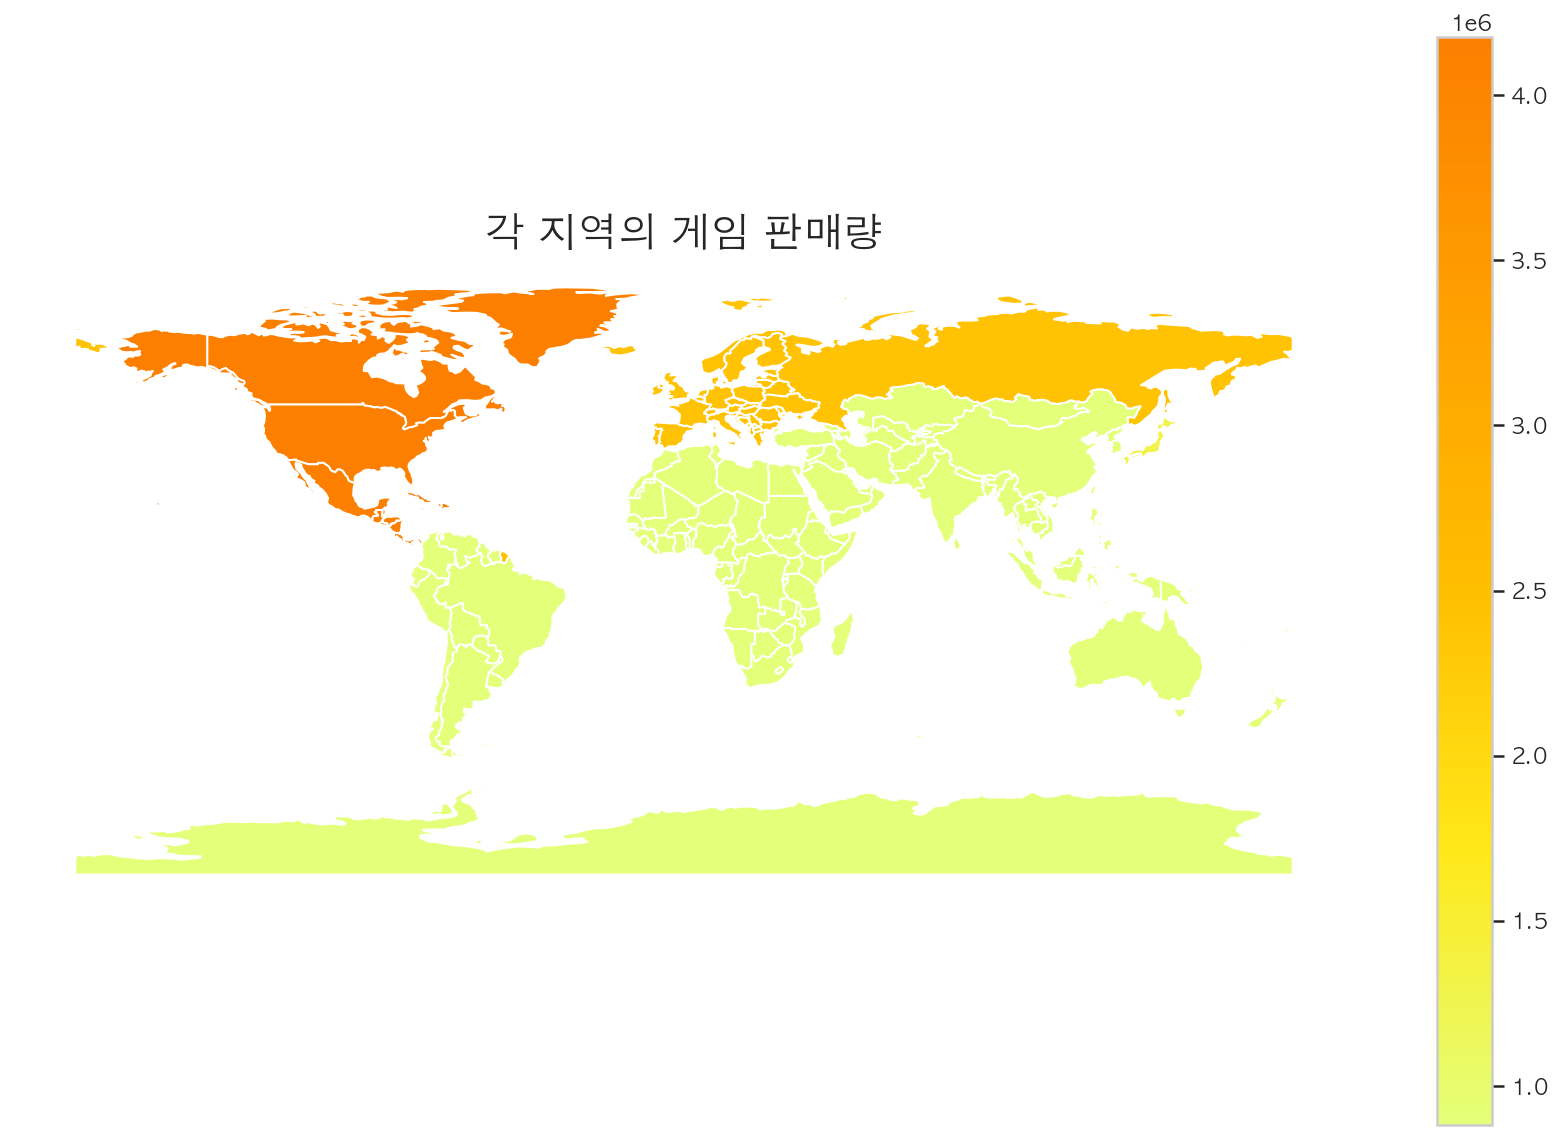

In [56]:

ax = df_continet.plot(column="Sales", legend=True, cmap="Wistia", figsize=(15, 10))
ax.set_title("각 지역의 게임 판매량", fontsize=20)

ax.set_axis_off()

> 가장 출고량이 많은 북미와 유럽 시장을 타겟으로 하는 것이 낫다.

## 게임 장르와 플랫폼의 연관 관계

- 귀무 가설 : 게임 장르와 플랫폼의 관계는 서로 독립이다.
- 대립 가설 : 게임 장르와 플랫폼의 관계는 서로 연관성이 있다.

- p-value < 0.05 이면 귀무 가설 기각, 대립 가설 채택.

In [57]:
df_crosstable = pd.crosstab(df['Genre'], df['Platform'])
df_crosstable.head()

Platform   2600  3DO  3DS  DC   DS  GB  GBA  GC  GEN  GG  ...  SAT  SCD  SNES  \
Genre                                                     ...                   
Action       55    0  180   3  335   6  162  98    3   0  ...    3    0    12   
Adventure     1    1   36  11  237   5   35  20    2   0  ...   26    0     4   
Fighting      1    0   14  12   36   0   23  42    5   0  ...   31    0    25   
Misc          5    0   53   0  388   8   86  35    1   0  ...   15    2    17   
Platform      9    0   28   2   89  18  139  73    7   1  ...    5    1    26   

Platform   TG16  WS  Wii  WiiU  X360   XB  XOne  
Genre                                            
Action        0   0  229    63   318  152    68  
Adventure     1   0   83     3    47   26    11  
Fighting      0   0   41     5    64   44     7  
Misc          0   0  270    21   122   45    15  
Platform      0   0   57    16    24   49     4  

[5 rows x 31 columns]

In [58]:
stats.chi2_contingency(df_crosstable)

(5814.04396345137,
 0.0,
 330,
 array([[2.29405063e+01, 5.98447989e-01, 9.93423662e+01, 1.03730985e+01,
         4.24100142e+02, 1.93498183e+01, 1.56394408e+02, 1.07920121e+02,
         5.38603190e+00, 1.99482663e-01, 6.24380735e+01, 1.95493010e+01,
         2.39379196e+00, 1.86516290e+02, 1.99482663e-01, 2.36386956e+02,
         4.23102728e+02, 2.59127979e+02, 6.66272095e+01, 2.37982817e+02,
         8.11894439e+01, 3.45105007e+01, 1.19689598e+00, 4.76763565e+01,
         3.98965326e-01, 1.19689598e+00, 2.56135739e+02, 2.85260208e+01,
         2.45563158e+02, 1.59386648e+02, 4.22903246e+01],
        [8.98072304e+00, 2.34279731e-01, 3.88904354e+01, 4.06084868e+00,
         1.66026236e+02, 7.57504465e+00, 6.12251032e+01, 4.22484449e+01,
         2.10851758e+00, 7.80932438e-02, 2.44431853e+01, 7.65313789e+00,
         9.37118926e-01, 7.30171830e+01, 7.80932438e-02, 9.25404939e+01,
         1.65635770e+02, 1.01443124e+02, 2.60831434e+01, 9.31652399e+01,
         3.17839502e+01, 1.35101312

> pvalue 값이 0.0 이므로 대립 가설이 채택 됩니다. 즉, 게임 장르와 플랫폼의 관계는 서로 연관성이 있습니다. 

**그럼, 어떤 장르와 플랫폼일 때, 게임 출고량이 우세할지 알아봅니다.**

In [60]:
# 장르에 따른 각 플랫폼별 게임 출고량

df_genre_platform = df.groupby(['Genre', 'Platform'])['Total'].sum().reset_index()
df_genre_platform.head()

Genre Platform     Total
0  Action     2600   26310.0
1  Action      3DS   56490.0
2  Action       DC    1260.0
3  Action       DS  113990.0
4  Action       GB    7930.0

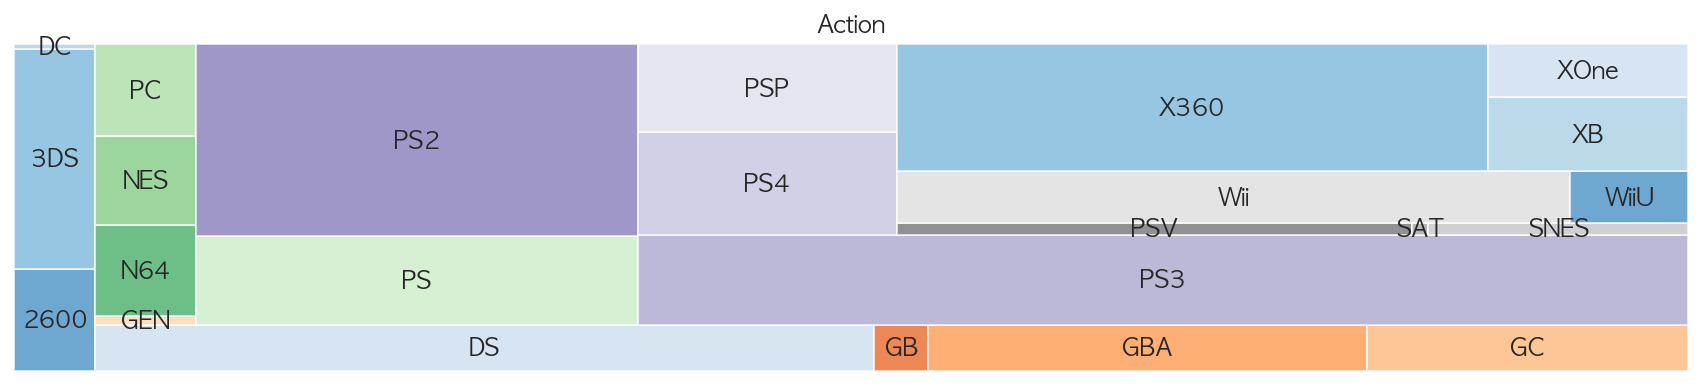

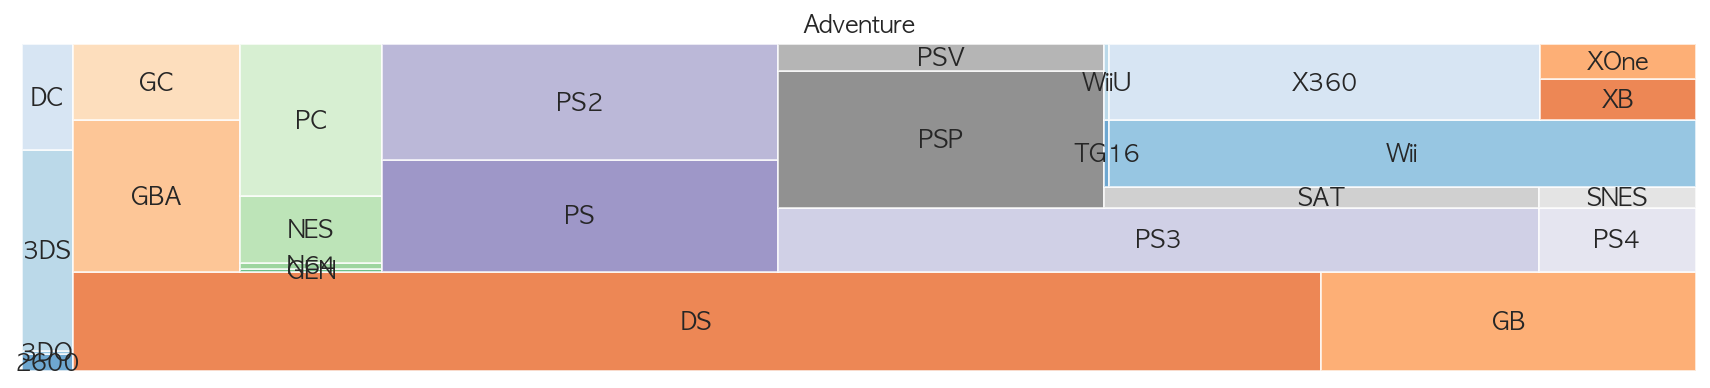

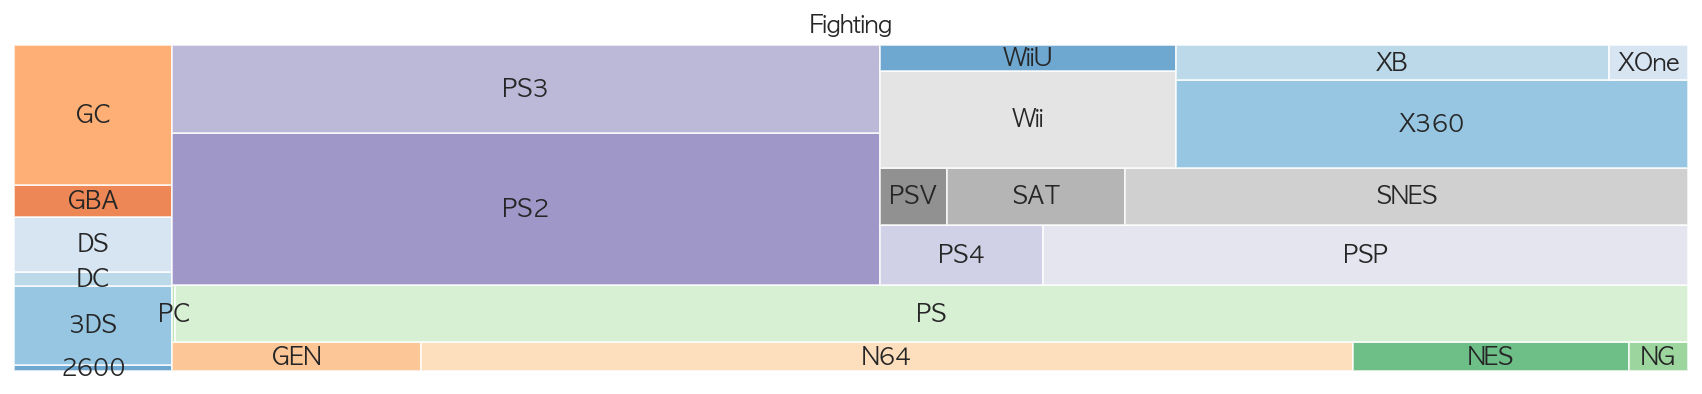

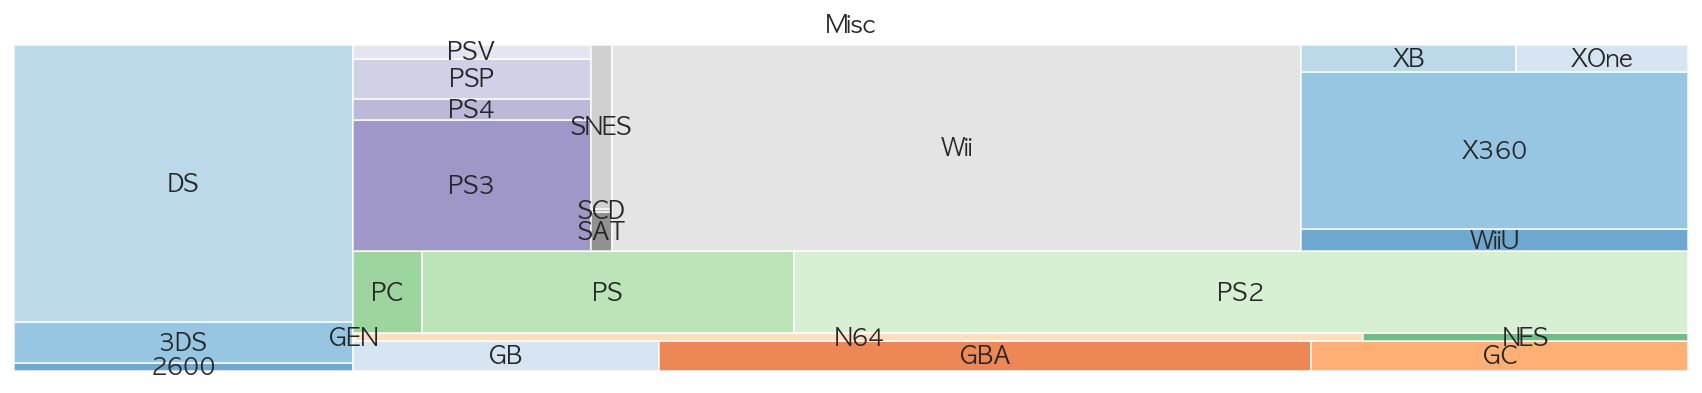

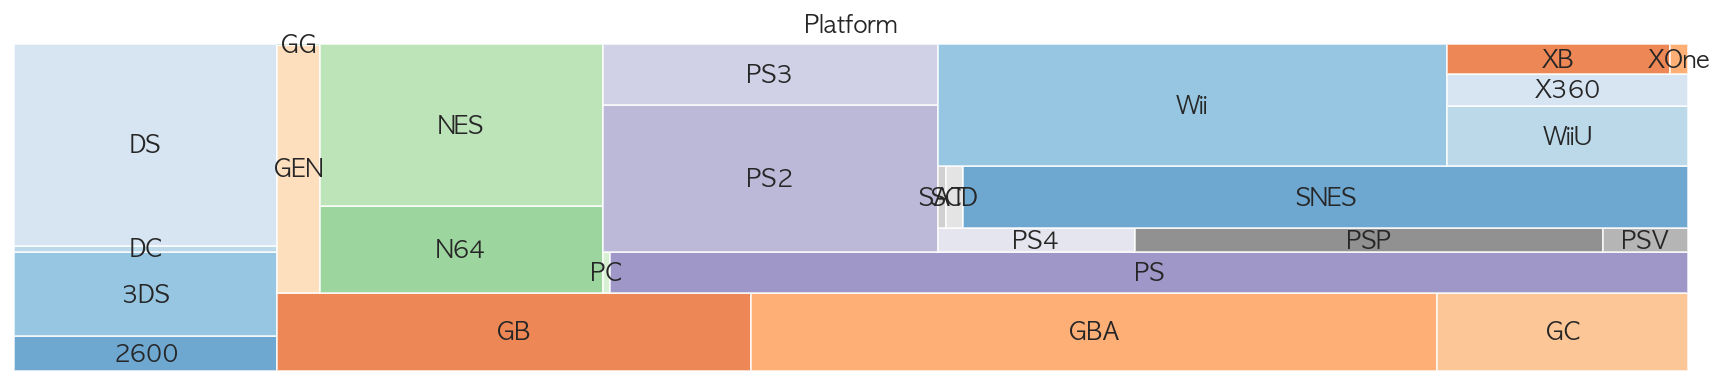

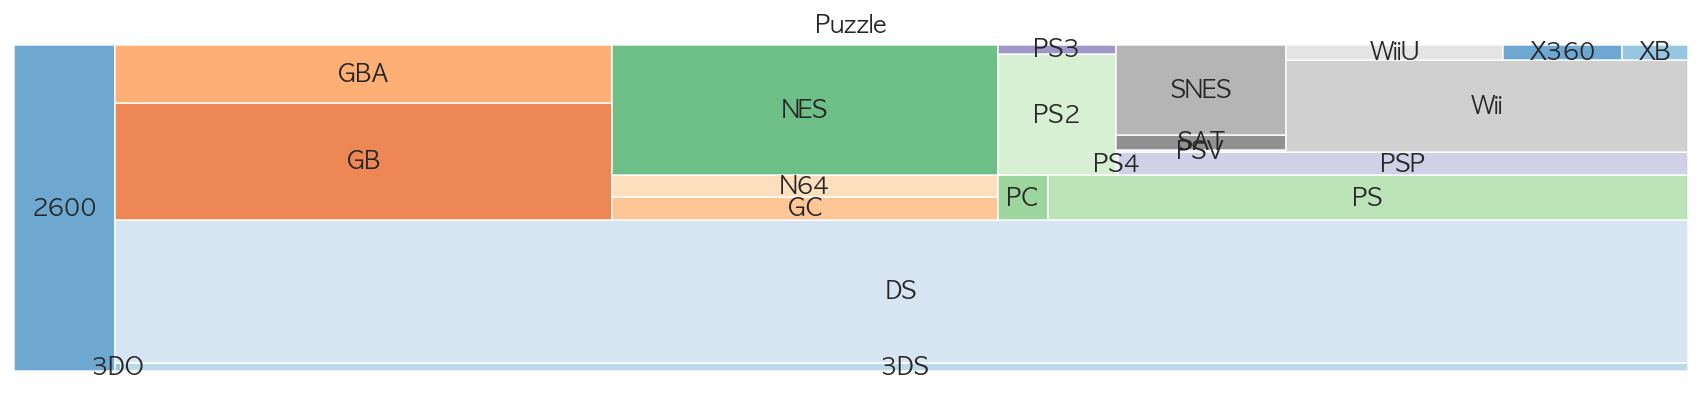

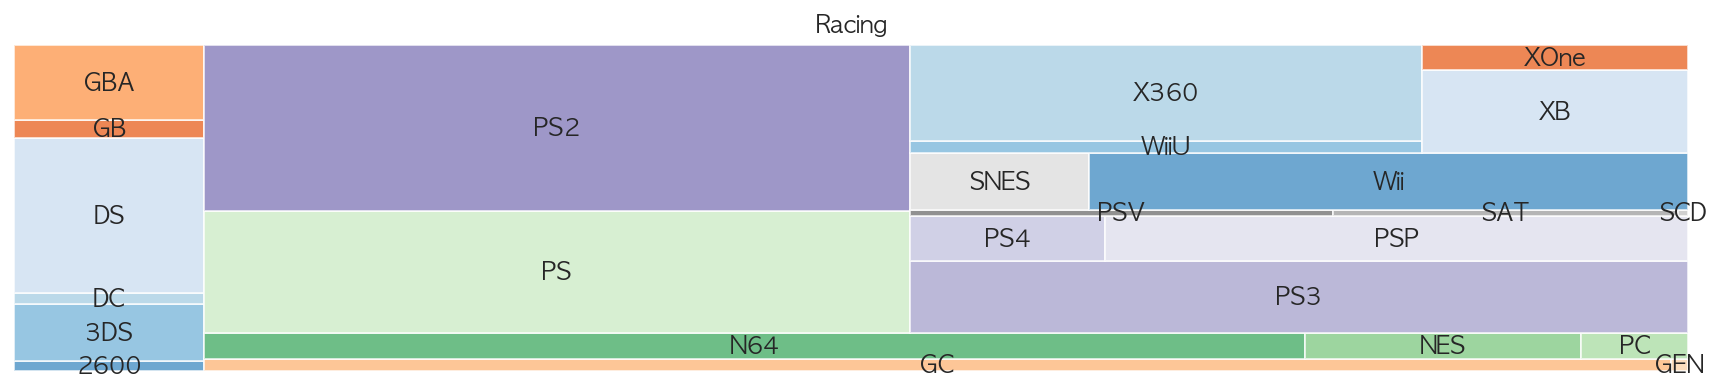

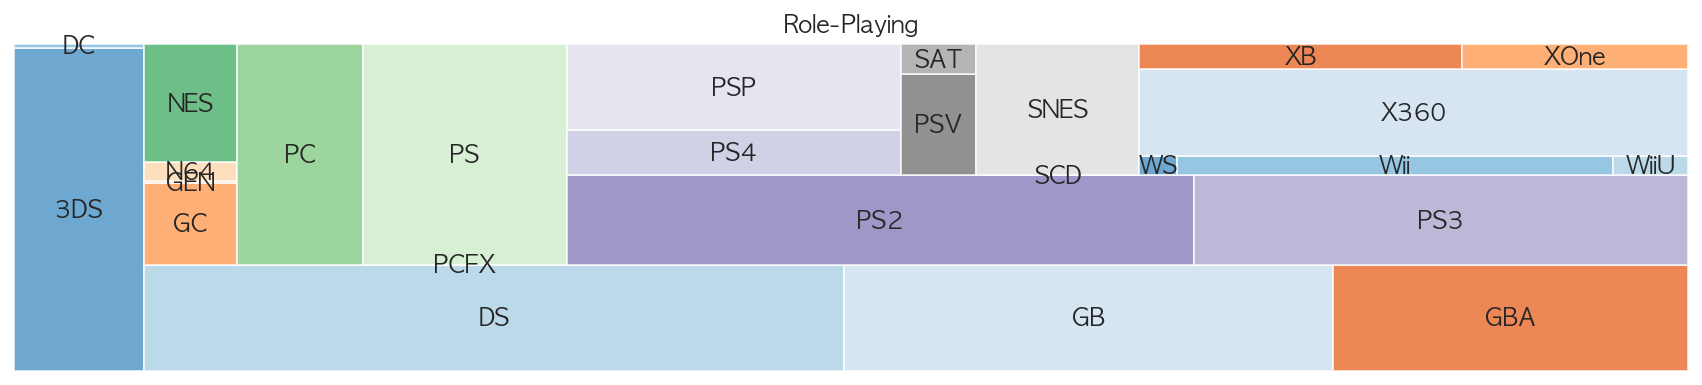

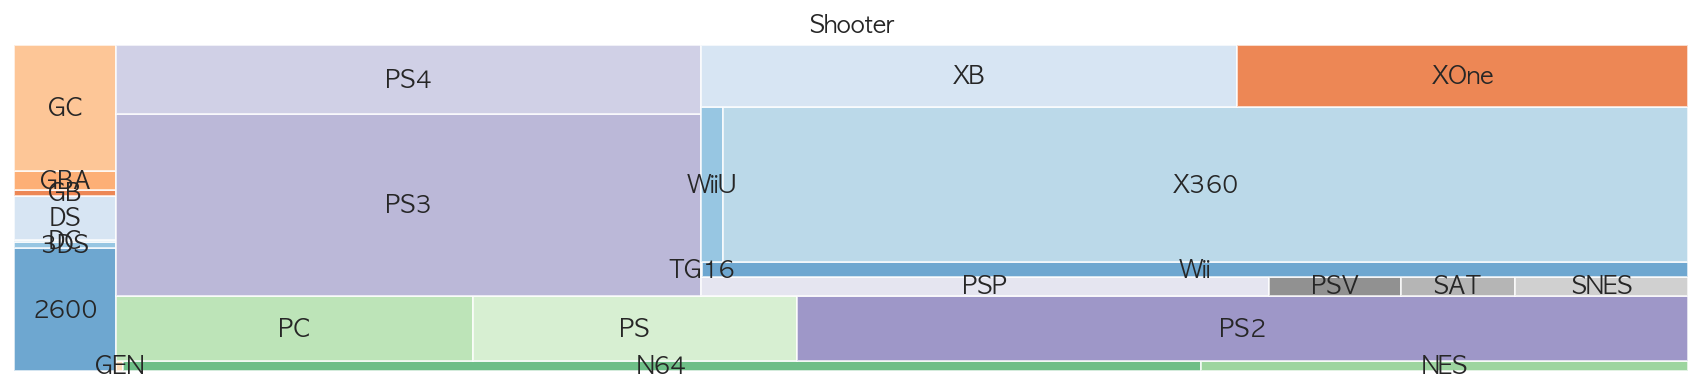

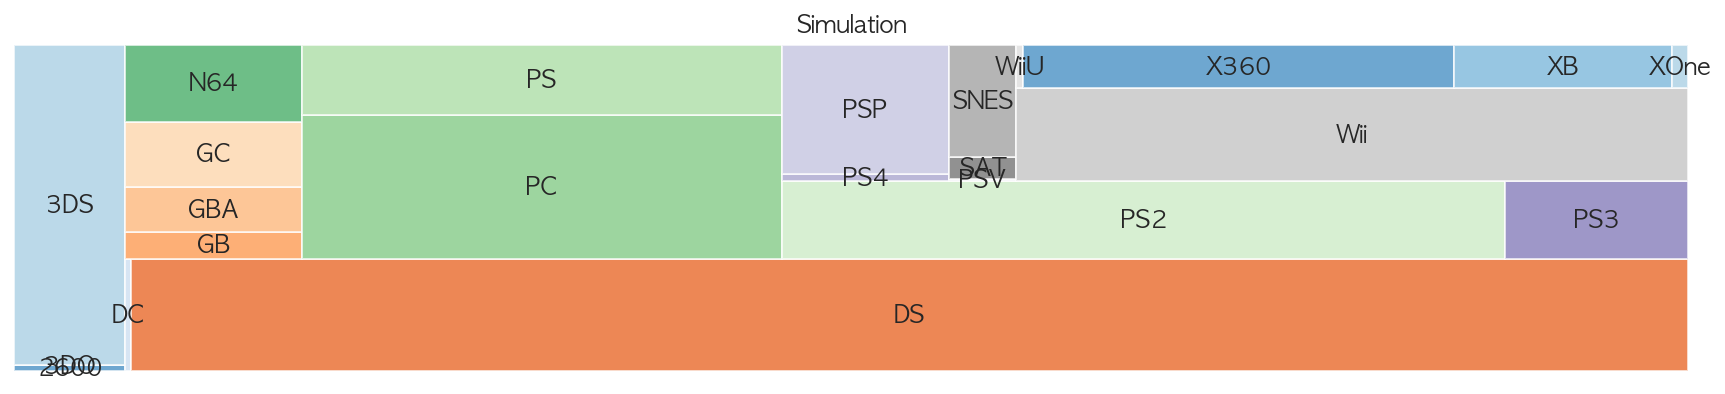

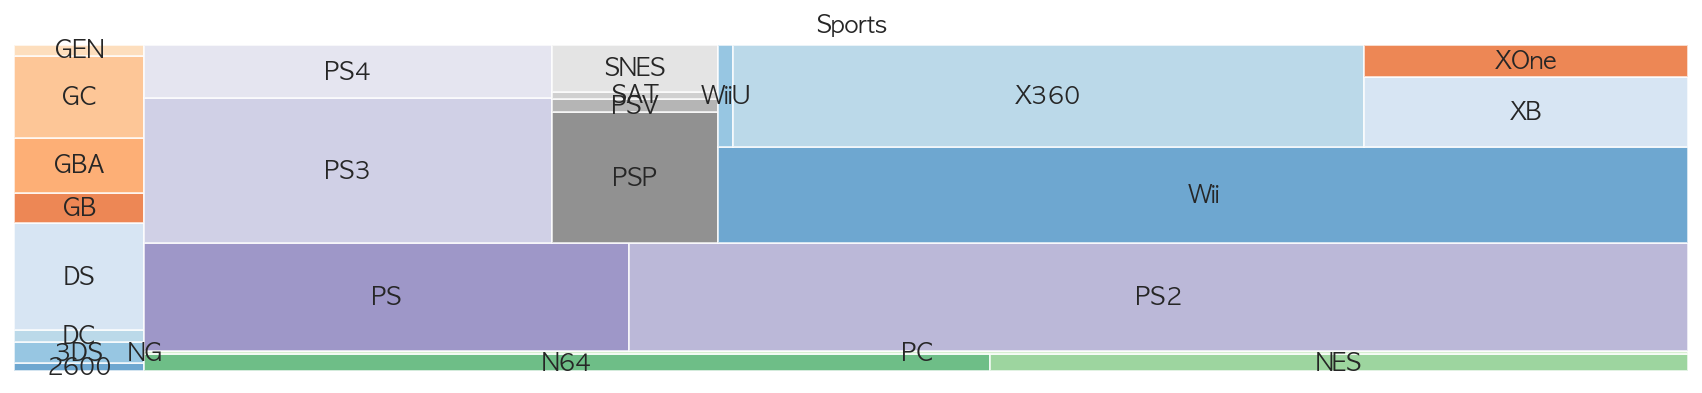

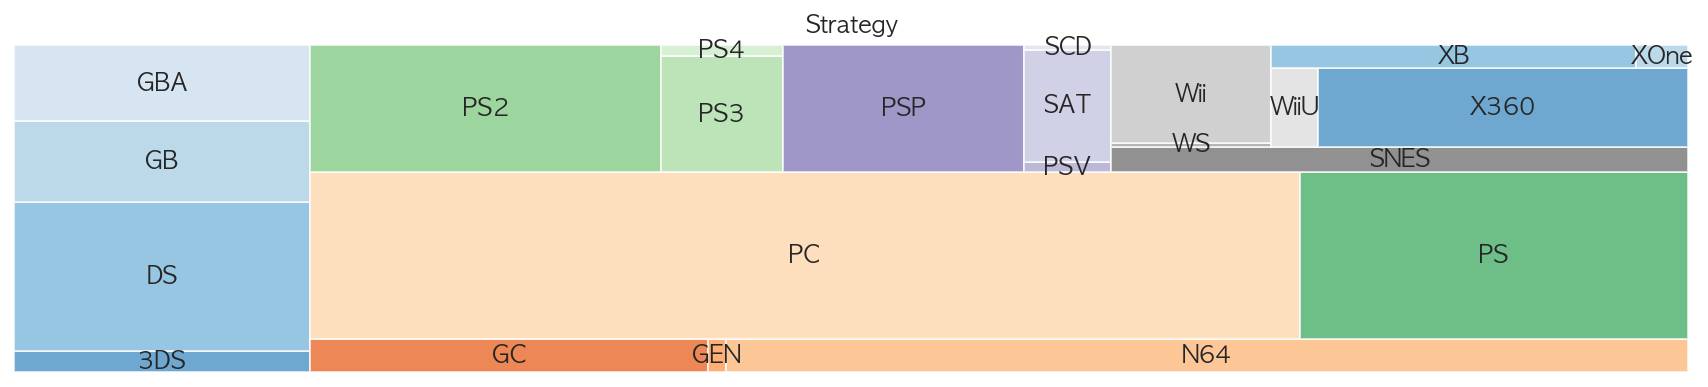

In [61]:
# Genre에 따라 플랫폼 
import squarify 

genre = df_genre_platform['Genre'].unique()

for i in range(len(genre)):
    df_treemap = df_genre_platform[df_genre_platform['Genre'] == genre[i]]
    plt.rcParams['figure.figsize'] = (15, 3)
    squarify.plot(sizes=df_treemap['Total'], label=df_treemap['Platform'], alpha=.7, color=plt.cm.tab20c.colors )
    plt.title(genre[i])
    plt.axis('off')
    plt.show()

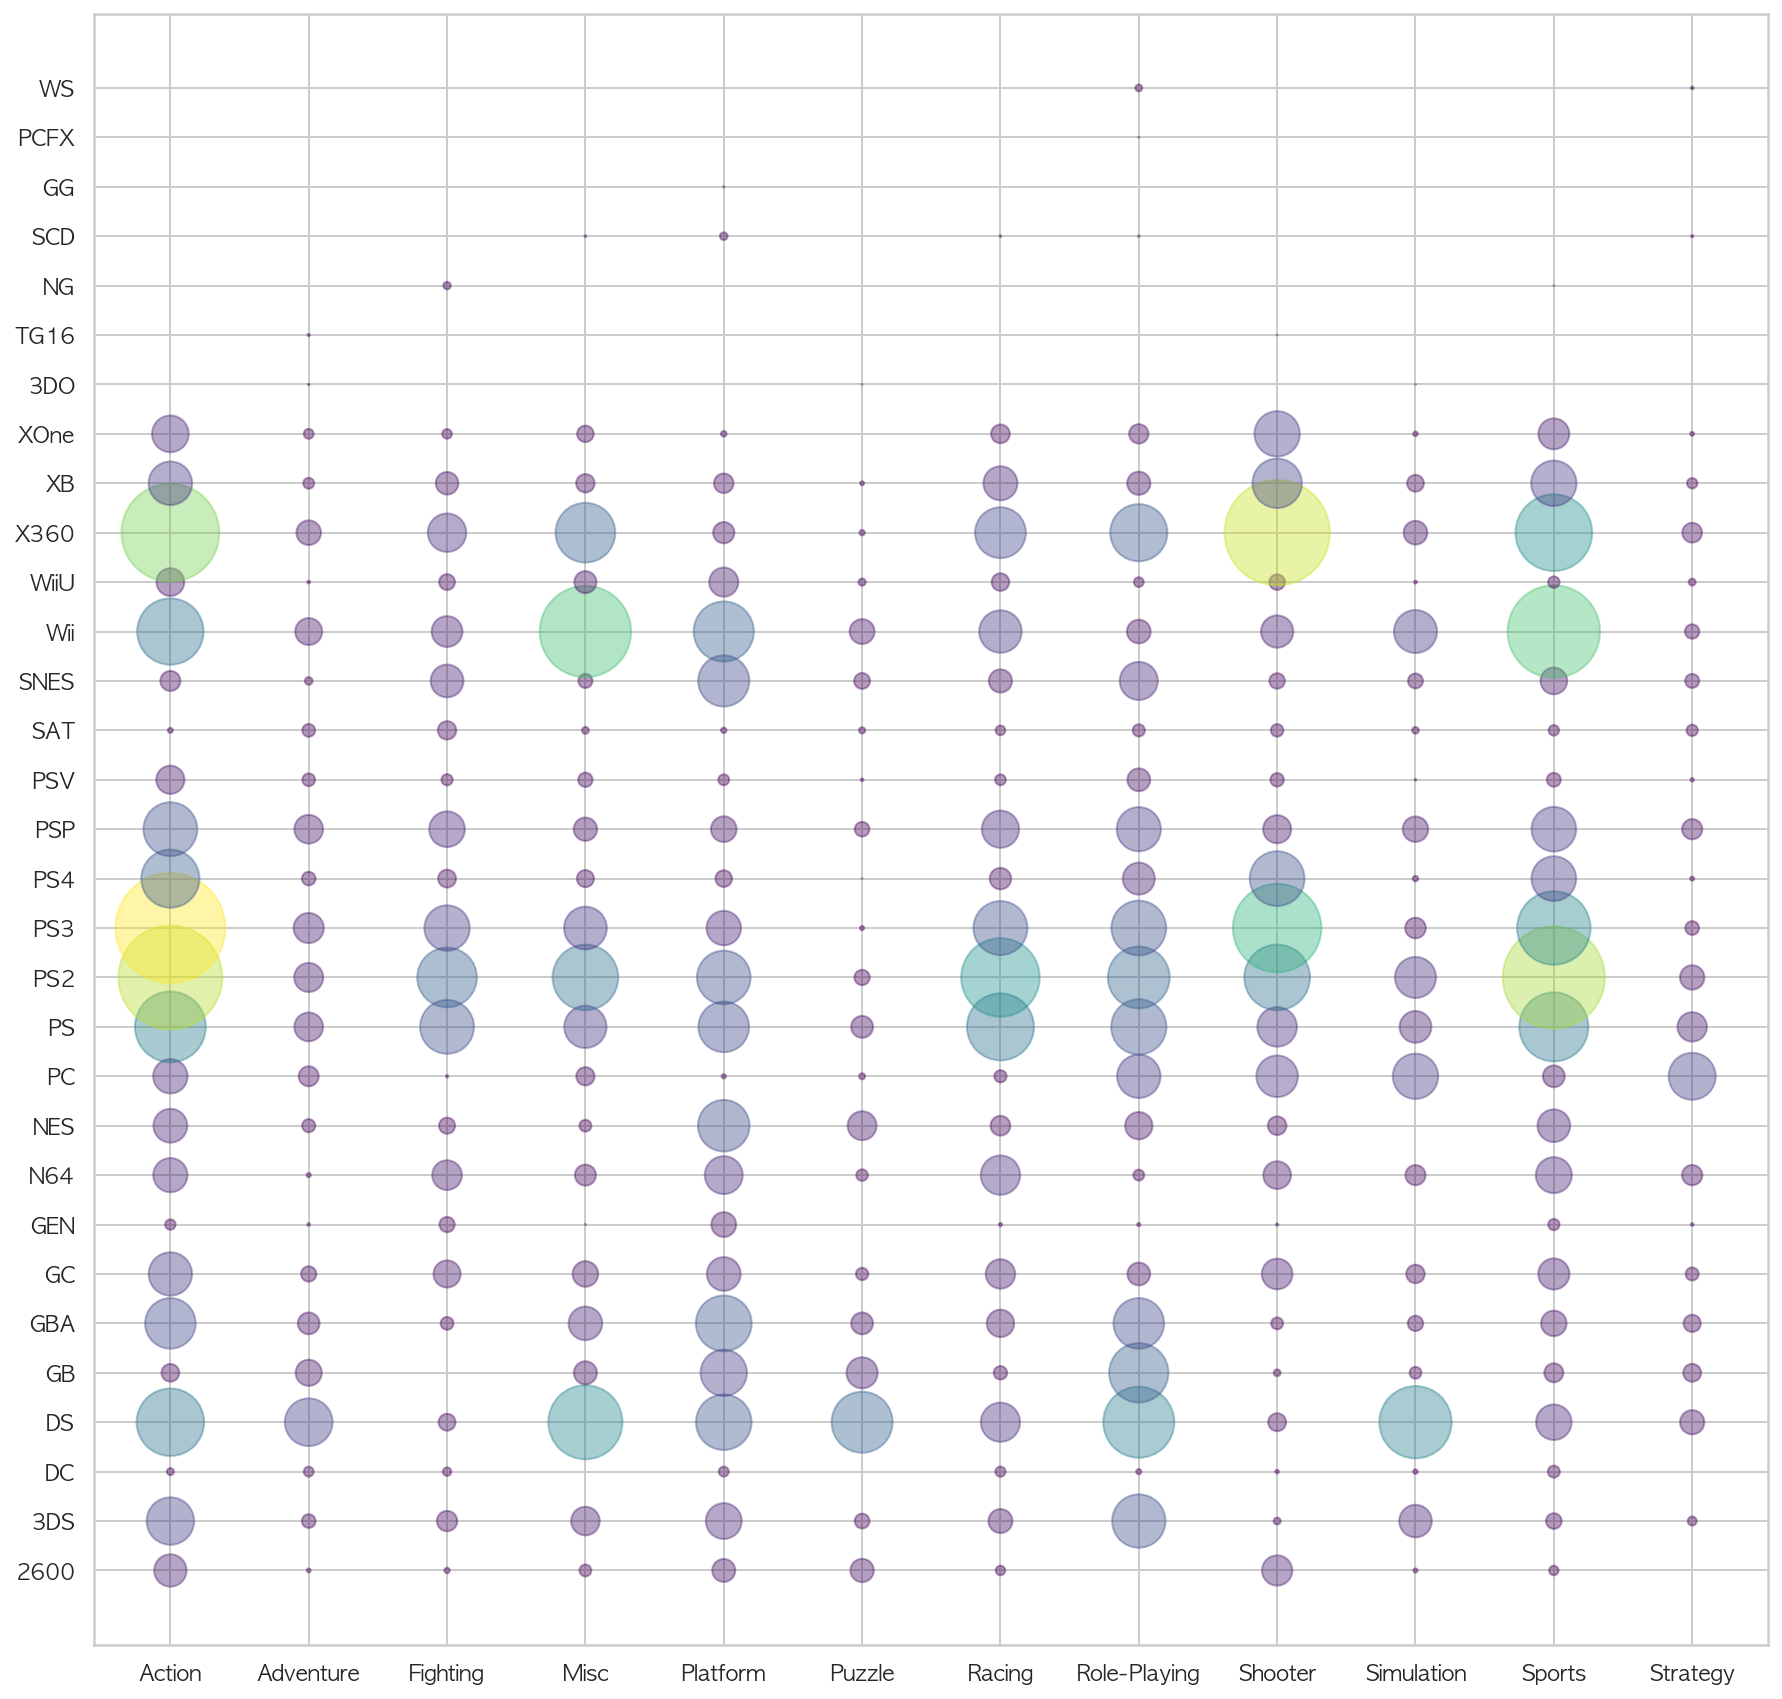

In [62]:
plt.figure(figsize=(15, 15))

plt.scatter(df_genre_platform['Genre'], df_genre_platform['Platform'], alpha=0.4, 
            s=df_genre_platform['Total']/100, c=df_genre_platform['Total'], cmap='viridis')
plt.show()

## 워드 클라우드로 게임 빈도수 표현

In [63]:
# 워드 클라우드를 시행하기 위한 함수

import re 
from wordcloud import WordCloud

def get_string(text):
    if pd.isna(text):
        return text
    
    text = re.sub("[\d\.'\-(nan)\[\]\/]", "", text)
    text = re.sub(" ", "", text)
    text = re.sub(",{2,}", ",", text)
    return text

def wordcloud(data, width=1200, height=500):
    word_draw = WordCloud(
        font_path=r"/Library/Fonts/NanumBarunGothic.ttf",
        width = width, height = height,
        background_color = 'white',
        random_state = 42
    )
    word_draw.generate(data)

    plt.figure(figsize=(15, 5))
    plt.imshow(word_draw)
    plt.axis('off')
    plt.show()

In [64]:
# 게임 이름을 game_name 에 담습니다.

game_name = str(df["Name"].tolist())
game_name = get_string(game_name)

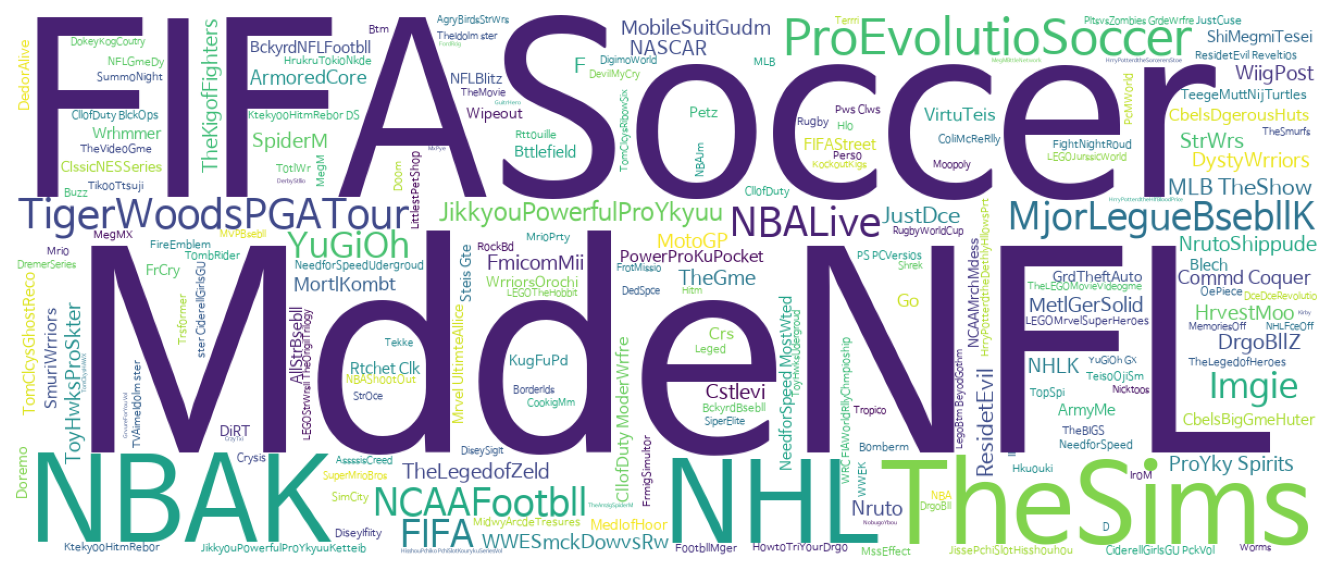

In [65]:
wordcloud(game_name)

> 스포츠 게임의 빈도수가 많은 것을 통해 스포츠 게임이 시리즈물로 제작되는 경우가 많음을 알 수 있다. 

## 스포츠 게임 장르와 스포츠 대회 개최 여부 상관 관계

In [134]:
# 월드컵과 올림픽이 개최된 연도 데이터를 불러옵니다.

df_worldcup_olympics = pd.read_csv("./worldcup_olympics.csv")
df_worldcup_olympics.head()

Year       Game      Continent  Open
0  1980   Olympics             EU     1
1  1980   Olympics  North America     1
2  1981        NaN            NaN     0
3  1982  World cup             EU     1
4  1983        NaN            NaN     0

In [135]:
# 연도별로 월드컵/올림픽 대회가 개최된 횟수를 구합니다.

df_worldcup_olympics = df_worldcup_olympics.groupby(['Year'])['Open'].sum().reset_index()
df_worldcup_olympics.head()

Year  Open
0  1980     2
1  1981     0
2  1982     1
3  1983     0
4  1984     2

In [136]:
# df_sports = df_genre_year.loc[:, ['Year', 'Sports']].reset_index()
df_sports = df_genre_year.loc[:, ['Year', 'Sports']]
df_sports.rename(columns = {'Sports' : 'Total'}, inplace = True)
df_sports['Year'] = pd.to_numeric(df_sports['Year'], downcast='integer')
df_sports.head()

Genre  Year   Total
0      1980     0.0
1      1981   780.0
2      1982  1060.0
3      1983  3200.0
4      1984  6170.0

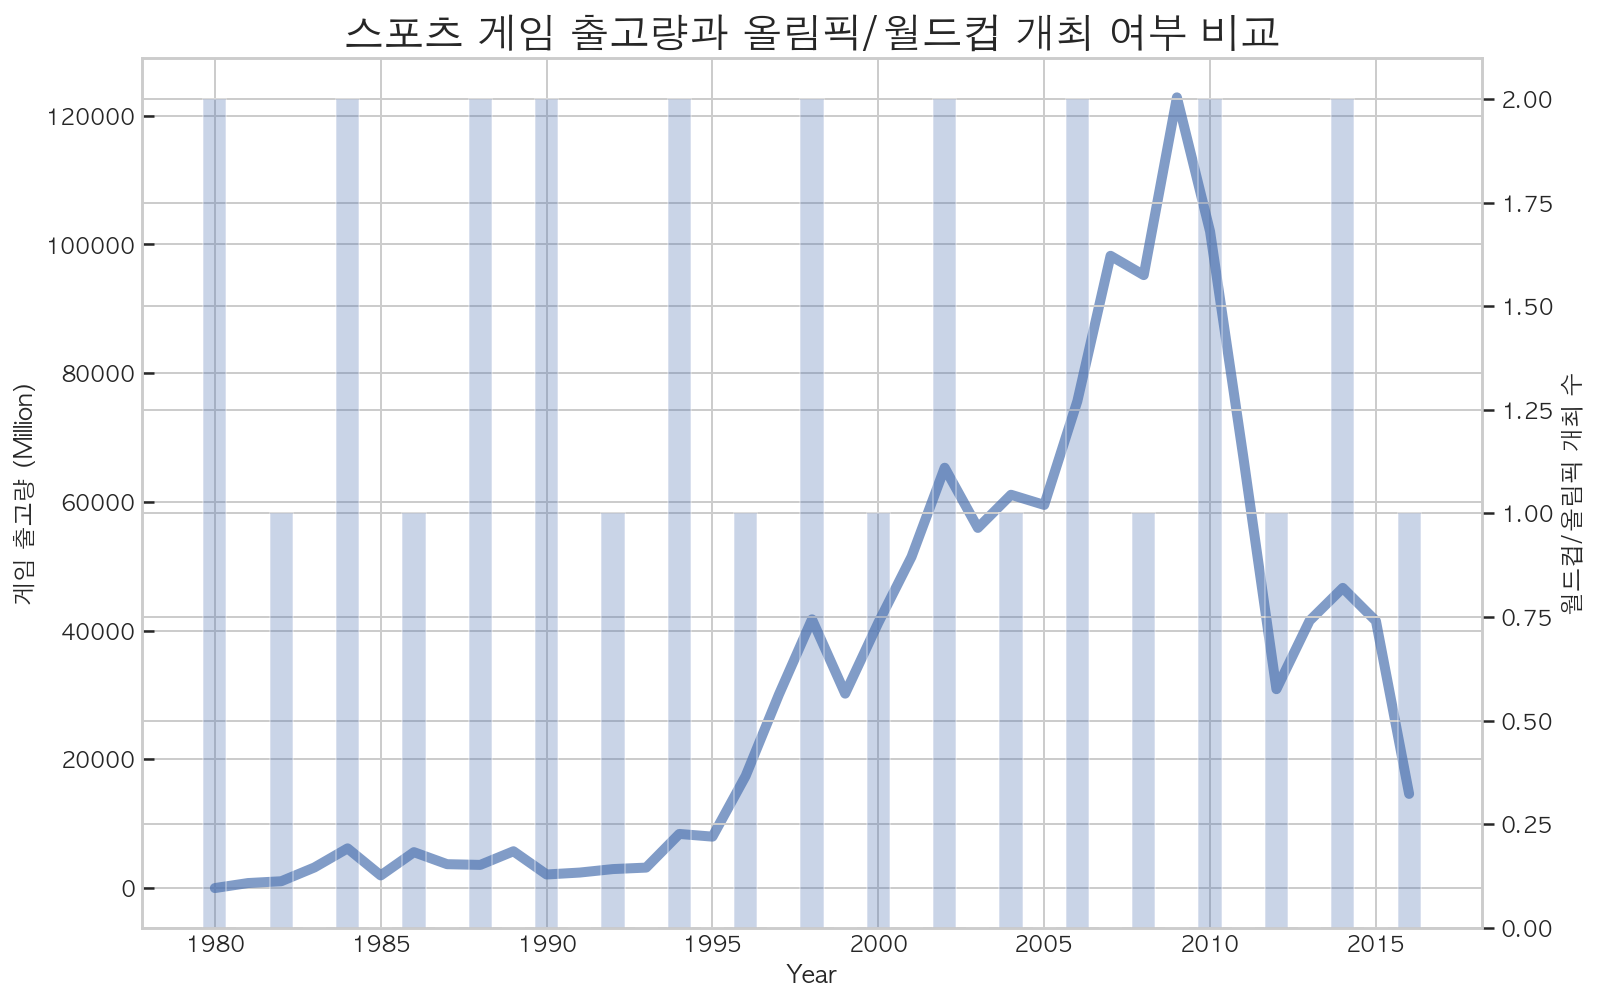

In [137]:
# 라인 그래프 : 스포츠 게임의 출고량
# 바 그래프 : 그 해에 올림픽/월드컵 개최수

plt.rcParams['figure.figsize'] = (12, 8)
fig, ax1 = plt.subplots()

ax1.plot(df_sports['Year'], df_sports['Total'],
         markersize=7, linewidth=5, alpha=0.7, label='출고량')
ax1.set_ylabel('게임 출고량 (Million)')
ax1.set_xlabel('Year')

ax1.tick_params(axis='both', direction='in')

ax2 = ax1.twinx()
ax2.bar(df_worldcup_olympics['Year'], df_worldcup_olympics['Open'], 
        label='Netflix Revenue', alpha=0.3, width=0.7)
ax2.set_ylabel('월드컵/올림픽 개최 수')

plt.title('스포츠 게임 출고량과 올림픽/월드컵 개최 여부 비교', fontsize=20)
plt.show()

In [138]:
# 월드컵/올림픽 개최 여부와 스포츠 게임 출고량은 서로 연관이 있는가 알아봅니다.

df_sports_crosstab = pd.crosstab(df_worldcup_olympics['Open'], df_sports['Total'])
df_sports_crosstab

Total  0.00       780.00     1060.00    1960.00    2110.00    2410.00    \
Open                                                                      
0              0          1          0          1          0          1   
1              0          0          1          0          0          0   
2              1          0          0          0          1          0   

Total  2950.00    3180.00    3200.00    3600.00    ...  55960.00   59530.00   \
Open                                               ...                         
0              0          1          1          0  ...          1          1   
1              1          0          0          0  ...          0          0   
2              0          0          0          1  ...          0          0   

Total  61110.00   65310.00   67050.00   75670.51   95240.00   98240.00   \
Open                                                                      
0              0          0          1          0          0          1   
1              1          0          0          0          1          0   
2              0          1          0          1          0          0   

Total  102010.00  122855.75  
Open                         
0              0          1  
1              0          0  
2              1          0  

[3 rows x 37 columns]

In [139]:
stats.chi2_contingency(df_sports_crosstab)

(74.00000000000003,
 0.4126968528321862,
 72,
 array([[0.48648649, 0.48648649, 0.48648649, 0.48648649, 0.48648649,
         0.48648649, 0.48648649, 0.48648649, 0.48648649, 0.48648649,
         0.48648649, 0.48648649, 0.48648649, 0.48648649, 0.48648649,
         0.48648649, 0.48648649, 0.48648649, 0.48648649, 0.48648649,
         0.48648649, 0.48648649, 0.48648649, 0.48648649, 0.48648649,
         0.48648649, 0.48648649, 0.48648649, 0.48648649, 0.48648649,
         0.48648649, 0.48648649, 0.48648649, 0.48648649, 0.48648649,
         0.48648649, 0.48648649],
        [0.24324324, 0.24324324, 0.24324324, 0.24324324, 0.24324324,
         0.24324324, 0.24324324, 0.24324324, 0.24324324, 0.24324324,
         0.24324324, 0.24324324, 0.24324324, 0.24324324, 0.24324324,
         0.24324324, 0.24324324, 0.24324324, 0.24324324, 0.24324324,
         0.24324324, 0.24324324, 0.24324324, 0.24324324, 0.24324324,
         0.24324324, 0.24324324, 0.24324324, 0.24324324, 0.24324324,
         0.24324324, 0.

> 귀무 가설 : 월드컵/올림픽 개최 여부는 그 해의 스포츠 게임 출고량은 서로 독립적이다.
대립 가설 : 월드컵/올림픽 개최 여부는 그 해의 스포츠 게임 출고량과 연관이 있다.

>**pvalue 값이 0.41, 즉 월드컵/올림픽 개최 여부는 그 해의 스포츠 게임 출고량과 독립적이다.**